# 05_WindForcing

Relation to large-scale patterns of atm. forcing

In [8]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_NSIDC.icedrift as icedrift
import data_UniBremen.SIC as unisic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def open_daily_winds(year, lat_range, lon_range, time_range = None):
    
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
    ds.close()
    if time_range == None:
        ds = ds.sel(latitude = lat_range, longitude = lon_range)
    else:
        ds = ds.sel(time = time_range, latitude = lat_range, longitude = lon_range)
        
    return ds

def open_daily_t2m(year, lat_range, lon_range, time_range = None):
    
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year}.nc')
    ds.close()
    
    if time_range == None:
        ds = ds.sel(latitude = lat_range, longitude = lon_range)
    else:
        ds = ds.sel(valid_time = time_range, latitude = lat_range, longitude = lon_range)
    
    return ds


def open_daily_drift(year, lat_range, lon_range, time_range = None):
    
    if type(time_range) == pd.Timestamp or type(time_range) == datetime:
        dates = time_range
    elif time_range == None:
        dates = pd.to_datetime(pd.date_range(datetime(year,1,1),datetime(year,12,31), freq='1D'))
    else:
        dates = pd.to_datetime(pd.date_range(time_range.start, time_range.stop, freq='1D'))
        
    drift = icedrift.open_local_file(dates, crop = [180,310,80,220],include_units = False)
    
    
    drift2 = {}
    drift2['u'] = drift['u']
    drift2['v'] = drift['v']
    drift2['e'] = drift['e']
    drift2['n'] = drift['n']
    
    drift2['proj'] = drift['proj']
    drift2['xx'] = drift['xx']
    drift2['yy'] = drift['yy']
    drift2['lon'] = drift['lon']
    drift2['lat'] = drift['lat']
    
    drift2['s'] = np.sqrt(drift['e']**2+drift['n']**2)

    return drift2



In [10]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

## Reference grids

In [11]:
grids = {}

# ERA5
#-----
# era_lat_range = slice(74,68)
# era_lon_range = slice(-165,-125)

era_lat_range = slice(90,65)
era_lon_range = slice(-180,180)
ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_2024_daily.nc')
ds.close()
ds = ds.sel(latitude = era_lat_range, longitude = era_lon_range)
longrid, latgrid = np.meshgrid(ds.longitude, ds.latitude)

grids['era'] = {}
grids['era']['lat'] = latgrid
grids['era']['lon'] = longrid


# PPD drift
#----------
drift = icedrift.open_local_file(datetime(2023,1,1), crop = [200,300,110,200],include_units = False)
drift['lon'][drift['lon']>180]-=360
grids['ppd'] = {}
grids['ppd']['lat'] = drift['lat']
grids['ppd']['lon'] = drift['lon']
grids['ppd']['xx'] = drift['xx']
grids['ppd']['yy'] = drift['yy']


# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v6.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))


from shapely.geometry import Point

for key in grids.keys():
    print(key)
    
    grids[key]['region'] = np.full(grids[key]['lon'].shape, False)

    for ii in range(np.shape(grids[key]['region'])[0]):
        for jj in range(np.shape(grids[key]['region'])[1]):

            lon, lat = grids[key]['lon'][ii,jj], grids[key]['lat'][ii,jj]
            if lon > 180:
                lon-=360

            if reg_poly.contains(Point(lon, lat)):
                
                if lon > -160:
                    grids[key]['region'][ii,jj] = True
                

era
ppd


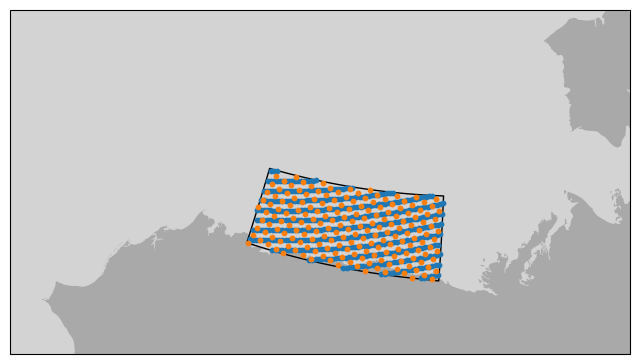

In [12]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


for key in ['era', 'ppd']:
    ax.scatter(grids[key]['lon'][grids[key]['region']], grids[key]['lat'][grids[key]['region']], 
               zorder=100, s = 10, transform=ccrs.PlateCarree())


In [6]:
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/SBSpolynya_data/open_freqs_2002-2025_M1.nc')

In [8]:
sic = unisic.open_local_file(datetime(2020,1,1), res='6250', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', crop=[0, None, 0, None], coordinates=False, area=False, include_units=False, quiet=True)


In [7]:

# key = 'era'
# mainpath = '../data/forcing/'
# filename = f"dailymaps_{key}_v0.nc"
# ds = xr.open_dataset(mainpath+filename)

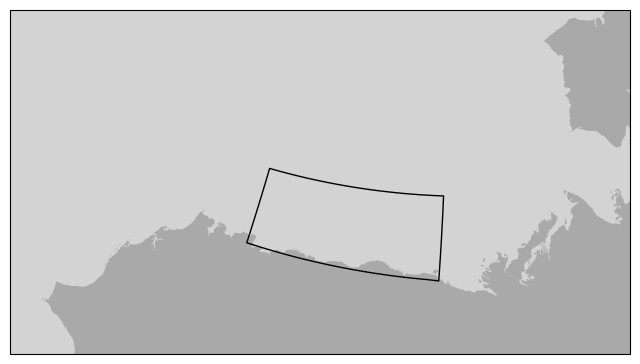

In [13]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree(), zorder=100)
# key = 'era'
# ax.pcolormesh(grids[key]['lon'], 
#               grids[key]['lat'], 
#               fieldmonth[key]['s10'][1]['mean'] - field[key]['s10']['mean'], vmin=-5, vmax=5, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


## Identify continuous polynya sequences

In [14]:

all_seqs = {}
all_sizes = {}

#===============================
years = np.append(np.arange(2003,2012), np.arange(2013,2024))
# years = np.arange(2003,2026)

size_thresh = 50      # polynya must reach this size at some point to be counted as event (km2)
start_size_thresh = 50  # size of openings to include as full window of event (km2)
#===============================

days_per_year = []
events_per_year = []


for year in years:
    
    print(year)
    
    # open data and crop to time range
    DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v6.nc')
    DS['length'] = DS.l_per95 - DS.l_per5
    DS['width'] = DS.w_per95 - DS.w_per5
    time_range = slice(datetime(year-1,12,1), datetime(year,3,31))
    DS = DS.sel(time = time_range)
    
    # identify open periods
    
    open_cond = (DS.extent > start_size_thresh) & (DS.ocean_extent == 0)
    open_dates = pd.to_datetime(DS.time[open_cond].values)
    days_per_year.append(len(open_dates))
    
    open_seqs = tseries.dates_to_sequences(open_dates, dt_max = 1 * units('day'))
    events_per_year.append(len(open_seqs))
    
    large_seqs = {}
    
    cc = 0
    for jj in range(len(open_seqs)):
        # if polynya reach size threshold during event, add to algre sequences
        if np.sum(DS.sel(time = open_seqs[jj]).extent.values > size_thresh) > 0:
            large_seqs[cc] = open_seqs[jj]
            cc+=1
        
    
    # add to master list
    ii = len(all_seqs)
    
    CC = 0
    for cc in range(len(large_seqs)):
        if len(large_seqs[cc]) > 1:
            all_seqs[ii+CC] = large_seqs[cc]
            all_sizes[ii+CC] = DS.extent.sel(time = large_seqs[cc]).values
            CC+=1
            
        
        

2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


<IPython.core.display.Javascript object>


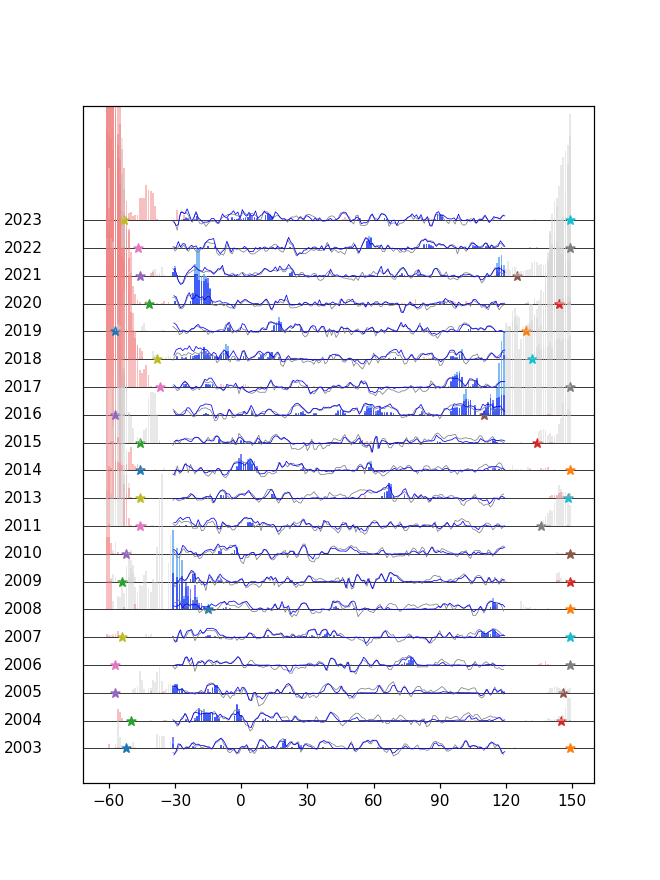

2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [54]:

    
fig, ax = plt.subplots(figsize=(6,8))


ax.set_xticks([-60,-30,0,30,60,90,120,150])
ax.set_yticks([])

ax.set_ylim(-10, 185)

daily_counts = {}
long_wind_counts = {}
wind_counts = {}
polynya_counts = {}
months = [12, 1, 2, 3, 4]
for month in months:
    long_wind_counts[month] = {}
    wind_counts[month] = {}
    polynya_counts[month] = {}
    daily_counts[month] = {}
    for year in years:
        long_wind_counts[month][year] = 0
        wind_counts[month][year] = 0
        polynya_counts[month][year] = 0
        daily_counts[month][year] = 0
    
wind_durations = np.array([])    
    
compare = {}
compare['open'] = {}
compare['large'] = {}
compare['comp'] = {}
compare['inc'] = {}
compare['dec'] = {}




groups = ['u10', 'v10', 't2m','msl', 'ui', 'vi', 'time']

for cat in compare.keys():
    compare[cat] = {}
    for group in groups:
        if group == 'time':
            compare[cat][group] = np.array([], dtype=np.datetime64)
        else:
            compare[cat][group] = np.array([])
        
        
        
annual_data = {}
annual_data['cum_polynya_extent'] = np.array([])
        
    
daily_data = {}
daily_data['ppd'] = {}
daily_data['era'] = {}
daily_data['pol'] = {}


daily_data['ppd']['ese'] = np.array([])
daily_data['ppd']['u'] = np.array([])
daily_data['ppd']['v'] = np.array([])
daily_data['ppd']['s'] = np.array([])
daily_data['ppd']['time'] = np.array([], dtype=np.datetime64)

daily_data['era']['ese'] = np.array([])
daily_data['era']['u'] = np.array([])
daily_data['era']['v'] = np.array([])
daily_data['era']['s'] = np.array([])
daily_data['era']['t2m'] = np.array([])
daily_data['era']['time'] = np.array([], dtype=np.datetime64)

daily_data['pol']['extent'] = np.array([])
daily_data['pol']['time'] = np.array([], dtype=np.datetime64)


# cond_data = {}
# cond_data['comp'] = {}
# cond_data['open'] = {}

# groups = ['u10', 'v10','t2m', 'ui', 'vi']
# for key in cond_data.keys():
#     for group in groups:
#         cond_data[key][group] = np.array([])


all_consol_dates = np.array([], dtype=np.datetime64)

all_closures = np.array([])
all_breakups = np.array([])
        
for yy, year in enumerate(years):
    
    YY = yy * 8
    ax.axhline(YY, c='k', lw=0.5, zorder=-1)
    ax.text(-90, YY, year, va='center', ha='right', clip_on=False)
    print(year)
    
    # open polynya data and crop to time range
    #-----------------------------------------
    DSo = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v6.nc')
    time_range = slice(datetime(year-1,11,1), datetime(year,1,1,0) + timedelta(days=119+30))
    DSo = DSo.sel(time = time_range)
    DSo['length'] = DSo['l_max'] - DSo['l_min']
    
    # find first and last closure dates
    dt_og = (pd.to_datetime(DSo.time.values) - datetime(year,1,1)).days
    
    ice_area = (DSo.ice_extent.values)
    water_area = (DSo.polynya_extent + DSo.other_polynya_extent)
    total_area = (ice_area + water_area)
    
    if yy == 0:
        ice_across_years = ice_area
        water_across_years = water_area
    else:
        ice_across_years = np.append(ice_across_years, ice_area)
        water_across_years = np.append(water_across_years, water_area)
    
    
    # fifth day of compact conditions
    closure_ind = np.where(ice_area/total_area > 0.99)[0][4]
    closure_date = dt_og[closure_ind]
    
    # last day of compact conditions
    breakup_ind = np.where(ice_area/total_area > 0.99)[0][-1]
    breakup_date = dt_og[breakup_ind]
    
    ax.scatter(closure_date, YY, marker='*')
    ax.scatter(breakup_date, YY, marker='*')
    
    # re-define dt
#     dt = (pd.to_datetime(DS.time.values) - datetime(year,1,1)).days
    # plot polynya data
    ax.bar(dt_og, DSo.polynya_extent/1000, bottom=YY, color='lightgray', alpha=0.5)
    ax.bar(dt_og, DSo.other_polynya_extent/1000, bottom=YY, color='lightcoral', alpha=0.5)
    
    all_closures = np.append(all_closures,closure_date)
    all_breakups = np.append(all_breakups,breakup_date)
    
    
#     DSo = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic15_v5.nc')
#     time_range = slice(datetime(year-1,12,1), datetime(year,4,30, 23))
#     DSo = DSo.sel(time = time_range)
#     DSo['length'] = DSo['l_max'] - DSo['l_min']
    
#     # find first and last closure dates
#     dt_og = (pd.to_datetime(DSo.time.values) - datetime(year,1,1)).days
    
#     ice_area = (DSo.ice_extent.values)
#     water_area = (DSo.polynya_extent + DSo.other_polynya_extent)
#     total_area = (ice_area + water_area)
    
    
    
#     first_closure_ind = np.where(ice_area/total_area > 0.99)[0][0]
#     first_closure_date = dt_og[first_closure_ind]
#     final_closure_ind = np.where(ice_area/total_area > 0.99)[0][-1]
#     final_closure_date = dt_og[final_closure_ind]
    
#     ax.scatter(first_closure_date, YY, marker='*')
#     ax.scatter(final_closure_date, YY, marker='*')
    
    # crop data between first, last closure dates
    closure_ind = np.where(dt_og==-31)[0][0]
    breakup_ind = np.where(dt_og==119)[0][0]

    DS = DSo.sel(time = slice(DSo.time[closure_ind],DSo.time[breakup_ind]))
    
    all_consol_dates = np.append(all_consol_dates, DS.time.values)
    
    # re-define dt
    dt = (pd.to_datetime(DS.time.values) - datetime(year,1,1)).days
    
    
    # save annual cumulative polynya area (over compact period)
    annual_data['cum_polynya_extent'] = np.append(annual_data['cum_polynya_extent'], np.nansum(DS.polynya_extent) )
    
    daily_data['pol']['extent'] = np.append(daily_data['pol']['extent'], DS.polynya_extent)
    daily_data['pol']['time'] = np.append(daily_data['pol']['time'], DS.time)
    
    # plot polynya data
    ax.bar(dt, DS.polynya_extent/1000, bottom=YY, color='dodgerblue', alpha=0.5)
    ax.bar(dt, DS.length/50, bottom=YY, color='b', alpha=0.5)
    
    
    open_cond = DS.polynya_extent > 0
    comp_cond = DS.polynya_extent == 0
    large_cond = DS.polynya_extent > 1500
    inc_cond = np.diff(DS.polynya_extent) > 0
    dec_cond = np.diff(DS.polynya_extent) < 0
    
    for group in ['time']:
        compare['open'][group] = np.append(compare['open'][group], DS[group].values[open_cond])
        compare['comp'][group] = np.append(compare['comp'][group], DS[group].values[comp_cond])
        compare['large'][group] = np.append(compare['large'][group], DS[group].values[large_cond])
        compare['inc'][group] = np.append(compare['inc'][group], DS[group][:-1].values[inc_cond])
        compare['dec'][group] = np.append(compare['dec'][group], DS[group][:-1].values[dec_cond])

    
    # open daily wind data and crop to time range
    #----------------------------------------------
    if year < 2024:
        ds = xr.open_dataset(f'../data/forcing/regional_daily_era_{year}_v6.nc')
        crop_ds = ds.sel(time=slice(pd.to_datetime(DS.time.values[0]), pd.to_datetime(DS.time.values[-1])))
        dt2 = (pd.to_datetime(crop_ds.time.values) - datetime(year,1,1)).total_seconds()/(60*60*24)
        ESE = vectors.comp_along_theta(crop_ds.u10.values, crop_ds.v10.values, (170)*units('degree'))
        
#         daily_data['era']['t2m'] = np.append(daily_data['era']['t2m'], crop_ds.t2m)
        daily_data['era']['s'] = np.append(daily_data['era']['s'], crop_ds.s10)
        daily_data['era']['u'] = np.append(daily_data['era']['u'], crop_ds.u10)
        daily_data['era']['v'] = np.append(daily_data['era']['v'], crop_ds.v10)
        daily_data['era']['ese'] = np.append(daily_data['era']['ese'], ESE)
        daily_data['era']['time'] = np.append(daily_data['era']['time'], crop_ds.time)

        
        for group in ['u10', 'v10',]:
            compare['open'][group] = np.append(compare['open'][group], crop_ds[group][open_cond])
            compare['comp'][group] = np.append(compare['comp'][group], crop_ds[group][comp_cond])
            compare['large'][group] = np.append(compare['large'][group], crop_ds[group][large_cond])
            compare['inc'][group] = np.append(compare['inc'][group], crop_ds[group][:-1][inc_cond])
            compare['dec'][group] = np.append(compare['dec'][group], crop_ds[group][:-1][dec_cond])
        
        ax.plot(dt2, YY + 0.2*ESE, c='gray', lw=0.5)
#         ax.plot(dt2, YY + 0.2*(crop_ds.t2m+20), c='r', lw=1, alpha=0.25)
    
    
    # open daily ice drift data and crop to time range
    #----------------------------------------------
    if year < 2024:
        dsp = xr.open_dataset(f'../data/forcing/regional_daily_ppd_{year}_v0.nc')
        dsp = dsp.sel(time = slice(DS.time[0], DS.time[-1]))
        dt = (pd.to_datetime(dsp.time.values) - datetime(year,1,1)).days
        ese = vectors.comp_along_theta(dsp.e.values, dsp.n.values, (162.5)*units('degree'))

        
        daily_data['ppd']['ese'] = np.append(daily_data['ppd']['ese'], ese)
        daily_data['ppd']['u'] = np.append(daily_data['ppd']['u'], dsp.e)
        daily_data['ppd']['v'] = np.append(daily_data['ppd']['v'], dsp.n)
        daily_data['ppd']['s'] = np.append(daily_data['ppd']['s'], dsp.s)
        daily_data['ppd']['time'] = np.append(daily_data['ppd']['time'], dsp.time)
        
        ax.plot(dt+0.5, YY+ 0.1*ese, c='b', lw=0.5)
        
        for og_name, group in zip(['e','n'],['ui', 'vi']):
            compare['open'][group] = np.append(compare['open'][group], dsp[og_name][open_cond])
            compare['comp'][group] = np.append(compare['comp'][group], dsp[og_name][comp_cond])
            compare['large'][group] = np.append(compare['large'][group], dsp[og_name][large_cond])
            compare['inc'][group] = np.append(compare['inc'][group], dsp[og_name][:-1][inc_cond])
            compare['dec'][group] = np.append(compare['dec'][group], dsp[og_name][:-1][dec_cond])
    
    
 

fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=330, bbox_inches='tight')

ice_across_years = np.reshape(ice_across_years, (len(years), len(dt_og)))
water_across_years = np.reshape(water_across_years, (len(years), len(dt_og)))

for cat in compare.keys():
    compare[cat]['time'] = pd.to_datetime(compare[cat]['time'])
    compare[cat]['a10'] = vectors.vector_angle(compare[cat]['u10'], compare[cat]['v10']).magnitude
    compare[cat]['s10'] = np.sqrt(compare[cat]['u10']**2 + compare[cat]['v10']**2)
    compare[cat]['ai'] = vectors.vector_angle(compare[cat]['ui'], compare[cat]['vi']).magnitude
    compare[cat]['si'] = np.sqrt(compare[cat]['ui']**2 + compare[cat]['vi']**2)
    
    
    
# find vector angles
daily_data['era']['angle'] = vectors.vector_angle(daily_data['era']['u'],daily_data['era']['v']).magnitude
daily_data['ppd']['angle'] = vectors.vector_angle(daily_data['ppd']['u'],daily_data['ppd']['v']).magnitude

all_consol_dates = pd.to_datetime(all_consol_dates)

In [56]:
open_sizes = daily_data['pol']['extent'][daily_data['pol']['extent'] > 0]

open_sizes

In [74]:
np.sum(open_sizes > 500)/len(open_sizes)

0.4989384288747346

In [73]:
np.nanmedian(open_sizes)

468.0864869907252

In [67]:
daily_data['pol'].keys()

dict_keys(['extent', 'time'])

In [68]:
daily_data['pol']['time'][np.where(daily_data['pol']['extent']>17500)]

array(['2007-12-01T00:00:00.000000000', '2007-12-03T00:00:00.000000000',
       '2016-04-28T00:00:00.000000000', '2016-04-29T00:00:00.000000000'],
      dtype='datetime64[ns]')

<IPython.core.display.Javascript object>


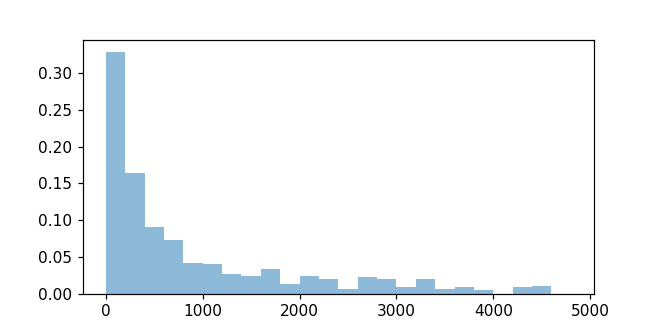

1391.118417451862


In [72]:

fig, ax = plt.subplots(figsize=(6,3))

bins = np.arange(0,5000,200)

x = open_sizes
h = plotter.quick_hist(x, bin_edges = bins)
ax.bar(h['centers'], h['prob'], width = h['w'], alpha=0.5)
print(np.nanmean(x))

-31 119


(-1000.0, 3000.0)

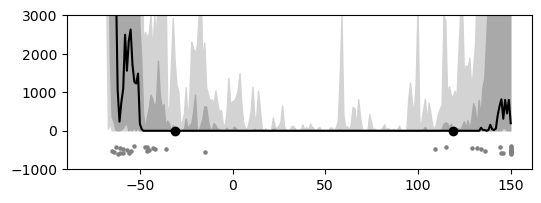

In [365]:
fig, ax = plt.subplots(figsize=(6,2))
plt.plot(dt_og, np.nanpercentile(water_across_years, 50, axis=0), c='k')
plt.fill_between(dt_og,
                 np.nanpercentile(water_across_years, 10, axis=0),
                 np.nanpercentile(water_across_years, 90, axis=0), color='lightgray')
plt.fill_between(dt_og,
                 np.nanpercentile(water_across_years, 25, axis=0),
                 np.nanpercentile(water_across_years, 75, axis=0), color='darkgray')

# COMPACT = round(np.nanpercentile(all_breakups,5))
# BROKEN = round(np.nanpercentile(all_closures,95))

COMPACT = -31
BROKEN = 119

print(COMPACT, BROKEN)

ax.scatter(COMPACT, 0, c='k')
ax.scatter(BROKEN, 0, c='k')

# ax.plot([np.nanpercentile(all_closures,0), np.nanpercentile(all_closures,100)], [-500,-500], c='gray')

ax.scatter(all_closures, np.linspace(-600,-400, len(all_closures)), c='gray', s=5)


# ax.plot([np.nanpercentile(all_breakups,0), np.nanpercentile(all_breakups,100)], [-500,-500], c='gray')
ax.scatter(all_breakups, np.linspace(-600,-400, len(all_breakups)), c='gray', s=5)


plt.ylim(-1000,3000)

# mostly_compact = np.nanpercentile(water_across_years, 90, axis=0)<1000
# mostly_compact = np.nanpercentile(water_across_years/(water_across_years + ice_across_years), 90, axis=0)<0.01
# plt.scatter(dt_og[mostly_compact], np.zeros(np.sum(mostly_compact)))

# water_frac = water_across_years/(water_across_years + ice_across_years)


# ax2 = ax.twinx()
# ax2.scatter(dt_og, np.sum(water_across_years < 1000, axis=0)/len(years), s=1)
# ax2.scatter(dt_og, np.sum(water_across_years < 100, axis=0)/len(years), s=1)
# ax2.scatter(dt_og, np.sum(water_frac<0.01, axis=0) / len(years))

# compact = np.sum(water_frac<0.01, axis=0) / len(years) > 0.9

# ax.scatter(dt_og[compact], np.zeros(np.sum(compact)))


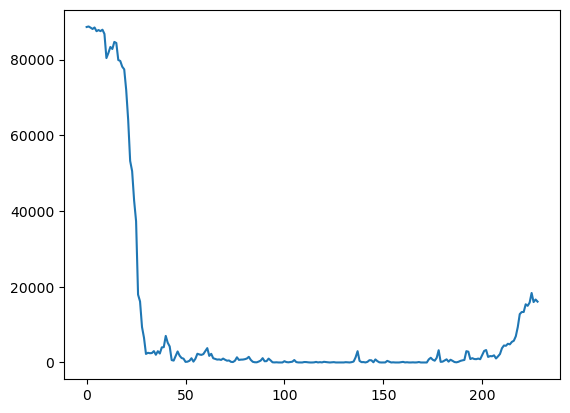

In [367]:
plt.plot(np.nanpercentile(water_across_years, 90, axis=0))

In [362]:
np.sum(all_breakups < 119)

2

In [363]:
np.sum(all_closures > -31)

1

In [353]:
DSo.time.values[np.where(dt_og==119)[0][0]]

numpy.datetime64('2023-04-30T00:00:00.000000000')

In [358]:
DSo.time.values[np.where(dt_og==-31)[0][0]]

numpy.datetime64('2022-12-01T00:00:00.000000000')

In [262]:
dt_og[compact].max()

108

In [120]:
open_extents = daily_data['pol']['extent'][daily_data['pol']['extent']>0]

In [146]:
np.sum(open_extents > 1500)/len(open_extents)

0.21784232365145229

In [594]:
sic_data = {}
for key in compare.keys():
    print(key)
    open_thresh=10
    sic_data[key] = unisic.calc_meansic_openfreq(pd.to_datetime(compare[key]['time']), crop=[500, 1300, 100, 500], 
                                        open_thresh=open_thresh, res='6250', hem='n', 
                                        main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                        coordinates=False, area=False, quiet=True)

open
large
comp
inc
dec


In [25]:
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

2.0 meter


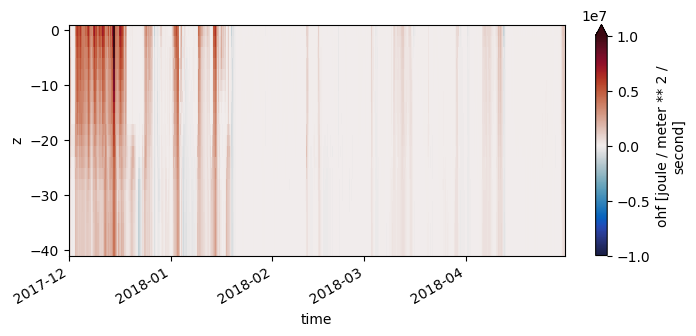

In [37]:
open_years = '2017_2018'

dsc = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/regridded/M1_OHT_{open_years}_v0.nc')
# dsc = dsc.sel(time=slice(datetime(2018,12,1), datetime(2019,2,10)))
# dsc = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/regridded/M1_OHT_2016_2017_v0.nc')

dsc['p'] = vectors.comp_along_theta(dsc['u'], dsc['v'], 145*units('degree'))


dsc['ohf'] = cst['Cp_o']*(dsc.sig0*units('kg/m3')) * (dsc.dT*units('delta_degC')) * (dsc.p*units('m/s'))
dsc['ohf']

dz = np.diff(dsc.z.values)[0] * units('m')
summed_OHT = np.sum((dsc['ohf'][:-1,:].values + dsc['ohf'][1:,:].values), axis=0) * units('joule/(meter2 second)')
print(dz)
int_OHT = 0.5 * summed_OHT * dz


fig, ax = plt.subplots(figsize=(8,3))
dsc['ohf'].plot(vmin=-10000000,vmax=10000000, cmap=cmocean.cm.balance)

In [38]:


Y1 = int(open_years.split('_')[0])
Y2 = int(open_years.split('_')[1])

dsa = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{Y1}.nc')
dsa.close()
dsa = dsa.sel(time=slice(dsc.time[0],dsa.time[-1]), latitude = 70, longitude=-139)
dsa['p'] = vectors.comp_along_theta(dsa['u10'], dsa['v10'], 170*units('degree'))


dsb = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{Y2}.nc')
dsb.close()
dsb = dsb.sel(time=slice(dsb.time[0], dsc.time[-1]), latitude = 70, longitude=-139)
dsb['p'] = vectors.comp_along_theta(dsb['u10'], dsb['v10'], 170*units('degree'))


In [39]:
wind_u = np.append(dsa['u10'].values, dsb['u10'].values)
zonal_stress = np.sign(wind_u)*wind_u**2
wind = np.append(dsa['p'].values, dsb['p'].values)
windspeed = np.append(np.sqrt(dsa['u10'].values**2+dsa['v10'].values**2), 
                      np.sqrt(dsb['u10'].values**2+dsb['v10'].values**2))
wind_stress = np.sign(wind)*wind**2

In [40]:
W = 20*units('km').to('m') # width of the shelf current
L = 100*units('km').to('m') # length of the shelf current
hourly_OHT = int_OHT * W
hourly_ice_suppression = (hourly_OHT/(cst['L_i']*cst['rho_i']*W*L)).to('cm/hour')


In [41]:
daily_OHT = tseries.running_mean(hourly_OHT, length=24, center=False, address_nans=False)
daily_wind = tseries.running_mean(wind, length=24, center=False, address_nans=False)
daily_stress = tseries.running_mean(wind_stress, length=24, center=False, address_nans=False)

current = dsc.p.mean('z').values
temp = dsc.dT.mean('z').values
sig = (dsc['sig0']).mean('z').values
temp_sig = (dsc.dT*dsc['sig0']).mean('z').values#.sel(z=slice(-20,0))

In [53]:
DS

<xarray.Dataset>
Dimensions:               (time: 151)
Coordinates:
  * time                  (time) datetime64[ns] 2022-12-01 ... 2023-04-30
Data variables: (12/25)
    N                     (time) float64 ...
    extent                (time) float64 ...
    l_min                 (time) float64 ...
    l_max                 (time) float64 ...
    l_mean                (time) float64 ...
    l_per5                (time) float64 ...
    ...                    ...
    ice_extent            (time) float64 1.129e+05 1.122e+05 ... 1.121e+05
    ocean_extent          (time) float64 ...
    other_polynya_extent  (time) float64 551.2 78.65 8.294e+03 ... 78.62 236.0
    polynya_extent        (time) float64 0.0 0.0 0.0 116.8 ... 0.0 0.0 0.0 0.0
    miss_flag             (time) bool ...
    length                (time) float64 nan nan nan 41.01 ... nan nan nan nan

<IPython.core.display.Javascript object>


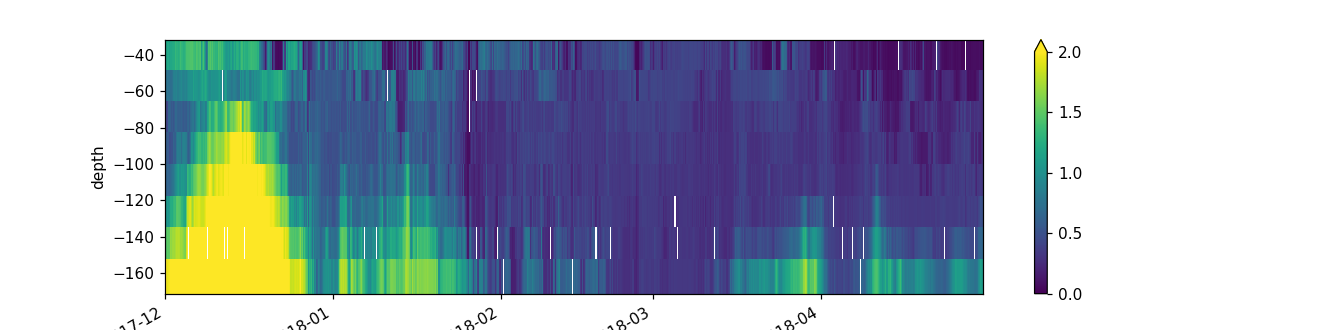

In [52]:
fig, ax = plt.subplots(figsize=(12,3))
(m2.T-m2.Tf).plot(vmin=0 ,vmax=2)

<IPython.core.display.Javascript object>


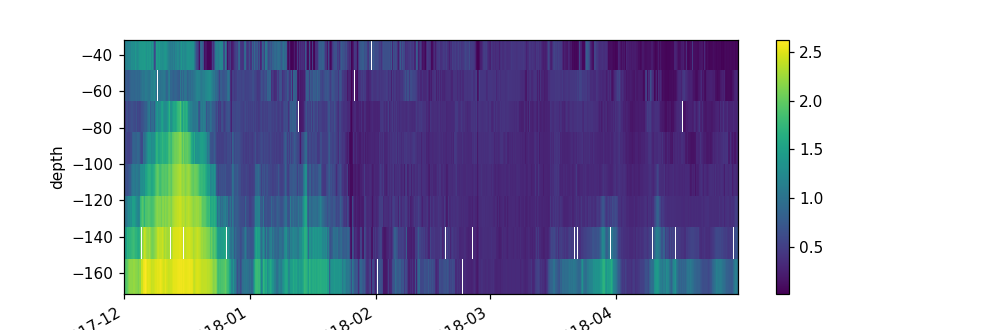

In [44]:

m1 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_{open_years}.nc')
m2 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_tempsalinity_{open_years}.nc')
m3 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_tempsalinity_{open_years}.nc')
m4 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_tempsalinity_{open_years}.nc')

time_range = slice(datetime(Y1,12,1), datetime(Y2,4,30,23))
m1 = m1.sel(time=time_range)
m2 = m2.sel(time=time_range)
m3 = m3.sel(time=time_range)
m4 = m4.sel(time=time_range)

PDdiff = m3.sig0.sel(depth = slice(-250,-80)).mean('depth')-m4.sig0.sel(depth = slice(-250,-80)).mean('depth')
CPD = m1.sig0.sel(depth=m1.depth.min())
# CPD = m1.sig0.sel(depth=m1.depth.max())
# CPD = m1.sig0.mean('depth')

uw2 = m2.sig0.sel(depth=m2.depth.min())
uw3 = m3.sig0.sel(depth=m3.depth.min())

%matplotlib notebook
fig, ax = plt.subplots(figsize=(9,3))
# m3.Ct.plot(vmin=-1.9, vmax=2, cmap='jet')
# dss.Sa.plot(vmin=29.5, vmax=31.5)
# dss.sig0.plot(vmin=23, vmax=26)

plt.plot(m3.time, PDdiff)
plt.plot(m1.time, CPD-25)

daily_CPD = tseries.running_mean(CPD.values, length=24, center=False, address_nans=True)
daily_current = tseries.running_mean(current, length=24, center=False, address_nans=False)

plt.plot(m1.time, daily_CPD-25)

plt.plot(m1.time, uw2-27)
# plt.plot(m1.time, 2*(uw3-25))



<IPython.core.display.Javascript object>


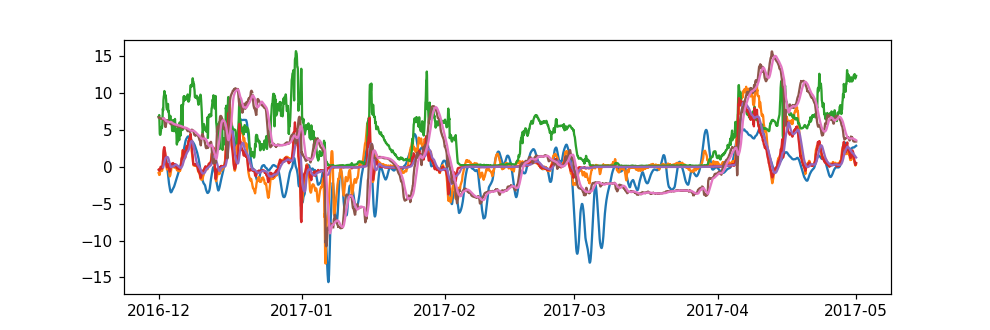

[]

In [715]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(9,3))
# plt.plot(dsc.time, int_OHT)

lag = 8
# plt.plot(dsc.time[lag:], wind[:-lag])
# plt.plot(dsc.time[lag:], wind_stress[:-lag]/20)
# plt.plot(dsc.time, wind_stress/20)
plt.plot(dsc.time, daily_stress/20)
plt.plot(dsc.time, current*10)
# plt.plot(dsc.time, sig/100)
plt.plot(dsc.time, temp_sig/100)
# plt.plot(dsc.time, daily_wind)
plt.plot(dsc.time, hourly_OHT.magnitude/300000000000)
plt.plot(dsc.time, daily_OHT.magnitude/300000000000)

# plt.plot(m3.time, 20*np.clip(PDdiff, -0.8,0.4)+5)
plt.plot(m3.time, 10*(CPD-25))

plt.plot(m3.time, 10*(daily_CPD-25))

plt.plot()


<IPython.core.display.Javascript object>


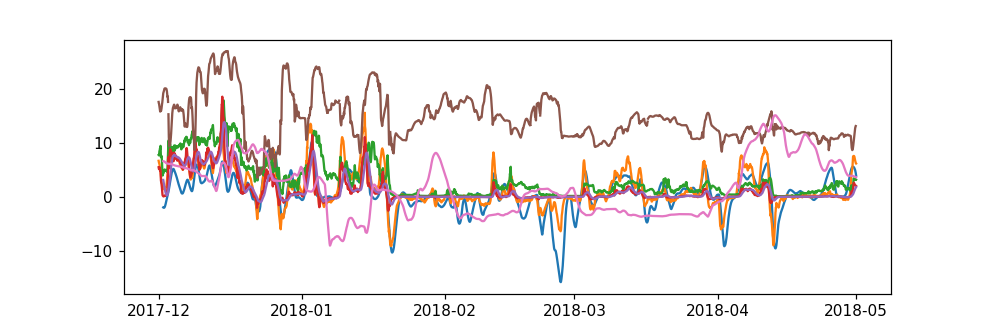

[]

In [744]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(9,3))
# plt.plot(dsc.time, int_OHT)

lag = 8
# plt.plot(dsc.time[lag:], wind[:-lag])
# plt.plot(dsc.time[lag:], wind_stress[:-lag]/20)
# plt.plot(dsc.time, wind_stress/20)
plt.plot(dsc.time, daily_stress/20)
plt.plot(dsc.time, current*10)
# plt.plot(dsc.time, sig/100)
plt.plot(dsc.time, temp_sig/100)
# plt.plot(dsc.time, daily_wind)
plt.plot(dsc.time, hourly_OHT.magnitude/300000000000)
plt.plot(dsc.time, daily_OHT.magnitude/300000000000)

# plt.plot(m3.time, 20*np.clip(PDdiff, -0.8,0.4)+5)
plt.plot(m3.time, 10*(CPD-25))

plt.plot(m3.time, 10*(daily_CPD-25))

plt.plot()


In [25]:


cmap = cmocean.tools.crop_by_percent(cmocean.cm.haline, 5, which='max', N=None)
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list( 'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = [-0.5,0.5,1.5,2.5,3.5,4.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

months = np.array([date.month for date in pd.to_datetime(dsc.time.values)])
monmap = np.copy(months)
monmap[months==12] = 0

In [26]:
np.diff(dsc.z)[0]

2.0

In [27]:
htz = cst['Cp_o']*(dsc.dT*units('delta_degC')*dsc.sig0*units('kg/m3')*dsc.p*units('m/s'))
hcz = cst['Cp_o']*(dsc.dT*units('delta_degC')*dsc.sig0*units('kg/m3'))
dz = np.diff(dsc.z)[0] * units('m')

IHC = np.sum(0.5*(hcz[1:,:].values + hcz[:-1,:].values), axis=0) * units('joule/meter3') * dz
IHT = np.sum(0.5*(htz[1:,:].values + htz[:-1,:].values), axis=0) * units('joule/(meter2 second)') * dz

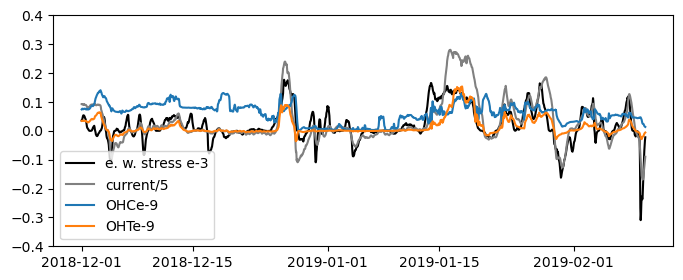

In [29]:
fig, ax = plt.subplots(figsize=(8,3))

plt.plot(dsc.time, -zonal_stress/1000, c='k', label='e. w. stress e-3')
plt.plot(dsc.time, current/5, c='gray', label='current/5')
plt.plot(dsc.time, IHC/(1e9), label='OHCe-9')
plt.plot(dsc.time, IHT.magnitude/(1e9), label='OHTe-9')

plt.legend()

plt.ylabel('')
plt.ylim(-0.4,0.4)

fig.savefig(f'../figures/mooring_relations/M1_timeseries_{open_years}.png', dpi=300, bbox_inches='tight')



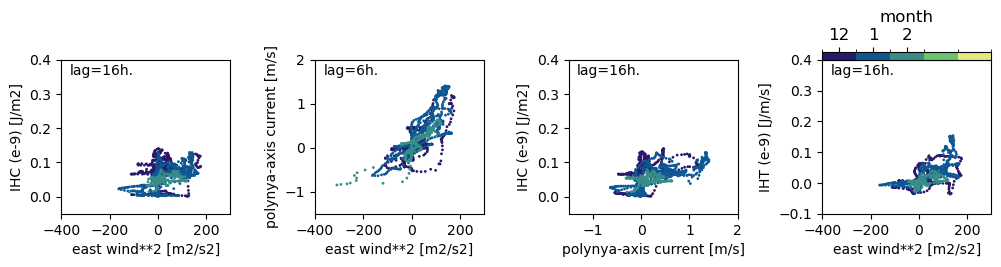

In [32]:
fig, axs = plt.subplots(1,4,figsize=(12,2))

plt.subplots_adjust(wspace=0.5)
# plt.scatter(wind_stress[:-lag], HC[lag:], s=1, c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]))

ax = axs[0]
lag = 16
ax.scatter(-zonal_stress[:-lag], IHC[lag:]/(1e9), s=1, c = monmap[:-lag], cmap=cmap, norm=norm)
ax.text(0.05,0.9,f'lag={lag}h.', transform=ax.transAxes)
ax.set_ylim(-0.05,0.4)
ax.set_xlim(-400,300)
ax.set_xlabel('east wind**2 [m2/s2]')
ax.set_ylabel('IHC (e-9) [J/m2]')

ax = axs[1]
lag = 6
ax.scatter(-zonal_stress[:-lag], current[lag:], s=1, c = monmap[:-lag], cmap=cmap, norm=norm)
ax.text(0.05,0.9,f'lag={lag}h.', transform=ax.transAxes)
ax.set_ylim(-1.5,2)
ax.set_xlim(-400,300)
ax.set_xlabel('east wind**2 [m2/s2]')
ax.set_ylabel('polynya-axis current [m/s]')


ax = axs[2]
lag = 16
ax.scatter(current[:-lag], IHC[lag:]/(1e9), s=1, c = monmap[:-lag], cmap=cmap, norm=norm)
ax.text(0.05,0.9,f'lag={lag}h.', transform=ax.transAxes)
ax.set_ylim(-0.05,0.4)
ax.set_xlim(-1.5,2)
ax.set_xlabel('polynya-axis current [m/s]')
ax.set_ylabel('IHC (e-9) [J/m2]')


ax = axs[3]
lag = 16
mesh = ax.scatter(-zonal_stress[:-lag], IHT[lag:]/(1e9), s=1, c = monmap[:-lag], cmap=cmap, norm=norm)
ax.text(0.05,0.9,f'lag={lag}h.', transform=ax.transAxes)
ax.set_ylim(-0.1,0.4)
ax.set_xlim(-400,300)
ax.set_xlabel('east wind**2 [m2/s2]')
ax.set_ylabel('IHT (e-9) [J/m/s]')

# plt.ylim(23.5,28)

# cb = plt.colorbar(mesh, ticks=list(set(monmap)), ticklabels=[12,1,2,3,4])

plotter.add_colorbar(fig, ax, [mesh], cb_placement='top',
             cb_orientation='auto', cb_width='auto', cb_length_fraction=[0, 1],
             cb_pad=0, cb_ticks=list(set(monmap)), cb_ticklabels=[12,1,2,], cb_extend='neither', 
             cb_label='month', labelpad='auto', cb_label_placement='auto', 
             cb_tick_placement='auto', tick_kwargs=None, cb_labelsize=12, 
             draw_edges=False, edge_params=['k', 2])


# fig.savefig(f'../figures/mooring_relations/M1_wind_current_heat_{open_years}.png', dpi=300, bbox_inches='tight')


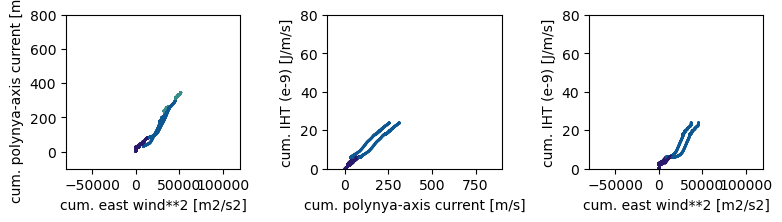

In [36]:
fig, axs = plt.subplots(1,3,figsize=(9,2))
# plt.scatter(np.cumsum(-zonal_stress), np.cumsum(IHT)/(1e9), s=1,  c = monmap, cmap=cmap, norm=norm)

plt.subplots_adjust(wspace=0.5)

cum_forc = np.copy(-zonal_stress)
cum_forc[cum_forc<0] =0 

p_current = np.copy(current)
p_current[p_current<0] =0

ax = axs[0]
ax.scatter(np.cumsum(-zonal_stress),np.cumsum(current), s=1,  c = monmap, cmap=cmap, norm=norm)
ax.scatter(np.cumsum(cum_forc),np.cumsum(p_current), s=1,  c = monmap, cmap=cmap, norm=norm)
ax.set_xlim(-80000,120000)
ax.set_ylim(-100,800)
ax.set_xlabel('cum. east wind**2 [m2/s2]')
ax.set_ylabel('cum. polynya-axis current [m/s]')


ax = axs[1]
ax.scatter(np.cumsum(current), np.cumsum(IHT)/(1e9), s=1,  c = monmap, cmap=cmap, norm=norm)
ax.scatter(np.cumsum(p_current), np.cumsum(IHT)/(1e9), s=1,  c = monmap, cmap=cmap, norm=norm)
ax.set_xlim(-100,900)
ax.set_xlabel('cum. polynya-axis current [m/s]')


ax = axs[2]
ax.scatter(np.cumsum(-zonal_stress), np.cumsum(IHT)/(1e9), s=1,  c = monmap, cmap=cmap, norm=norm)
ax.scatter(np.cumsum(cum_forc), np.cumsum(IHT)/(1e9), s=1,  c = monmap, cmap=cmap, norm=norm)
ax.set_xlim(-80000,120000)
ax.set_xlabel('cum. east wind**2 [m2/s2]')

# for ax in [axs[1],axs[2]]:
#     ax.set_ylim(0,250)
#     ax.set_ylabel('cum. IHC (e-9) [J/m2]')

for ax in [axs[1],axs[2]]:
    ax.set_ylim(0,80)
    ax.set_ylabel('cum. IHT (e-9) [J/m/s]')

fig.savefig(f'../figures/mooring_relations/M1_cum_relation_IHT_{open_years}.png', dpi=300, bbox_inches='tight')


In [830]:
open_years

'2017_2018'

In [639]:
list(set(monmap))

[0, 1, 2, 3, 4]

In [610]:
IHT

<Quantity([81861406.79192115 78828124.45429581 76460142.32450727 ...
 30740935.31401549 30403457.11788232 29918366.06103866], 'joule / meter / second')>

<IPython.core.display.Javascript object>


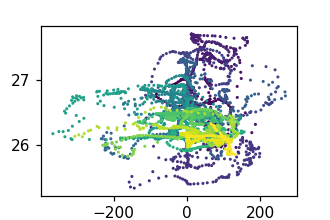

In [537]:
fig, ax= plt.subplots(figsize=(3,2))

lag = 6
# plt.scatter(wind_stress[:-lag][:1200], hourly_OHT[lag:][:1200], s=1)
# plt.scatter(wind_stress[:-lag][1200:], hourly_OHT[lag:][1200:], s=1)

# plt.scatter(daily_stress[:-lag], daily_OHT[lag:],  c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]), s=1)

# plt.scatter(daily_wind, daily_OHT, s=1 )#c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]), s=1)




# plt.scatter(wind_stress[:-lag], CPD[lag:], s=1, c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]))


plt.scatter(wind_stress[:-lag], CPD[lag:], s=1, c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]))




<IPython.core.display.Javascript object>


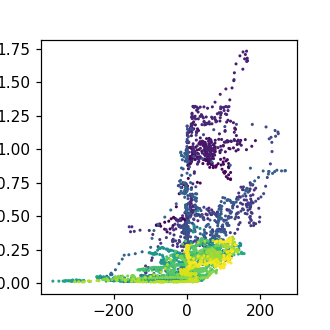

In [265]:
fig, ax= plt.subplots(figsize=(3,3))

lag = 12
# plt.scatter(wind_stress[:-lag][:1200], hourly_OHT[lag:][:1200], s=1)
# plt.scatter(wind_stress[:-lag][1200:], hourly_OHT[lag:][1200:], s=1)

# plt.scatter(daily_stress[:-lag], daily_OHT[lag:],  c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]), s=1)

# plt.scatter(daily_wind, daily_OHT, s=1 )#c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]), s=1)




plt.scatter(wind_stress[:-lag], temp[lag:], s=1, c = (np.arange(len(hourly_OHT[lag:])))/len(hourly_OHT[lag:]))





In [84]:
hourly_OHT.to('J/hour') * units('hour')

<Quantity([5.89402129e+15 5.67562496e+15 5.50513025e+15 ... 2.21334734e+15
 2.18904891e+15 2.15412236e+15], 'joule')>

In [43]:
int_OHT

<Quantity([81861406.79192115 78828124.45429583 76460142.32450727 ...
 30740935.31401549 30403457.11788232 29918366.06103866], 'meter')>

In [41]:
dsc['ohf']

<xarray.DataArray 'ohf' (z: 21, time: 3624)>
<Quantity([[1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 [1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 [1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 ...
 [2748254.47447597 2740307.93021627 2729259.50393234 ...  993781.10355016
   958245.79863375  891891.77872813]
 [2755814.72294445 2737307.66309984 2679338.8632171  ... 1057836.49119785
  1018126.54101719  942930.28429439]
 [2763374.97141293 2734307.3959834  2629418.22250187 ... 1121891.87884555
  1078007.28340063  993968.78986064]], 'joule / meter ** 2 / second')>
Coordinates:
  * time     (time) datetime64[ns] 2017-12-01 ... 2018-04-30T23:00:00
  * z        (z) float64 -40.0 -38.0 -36.0 -34.0 -32.0 ... -6.0 -4.0 -2.0 0.0

In [32]:
dsc['ohf']

<xarray.DataArray 'ohf' (z: 21, time: 3624)>
<Quantity([[1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 [1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 [1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 ...
 [2748254.47447597 2740307.93021627 2729259.50393234 ...  993781.10355016
   958245.79863375  891891.77872813]
 [2755814.72294445 2737307.66309984 2679338.8632171  ... 1057836.49119785
  1018126.54101719  942930.28429439]
 [2763374.97141293 2734307.3959834  2629418.22250187 ... 1121891.87884555
  1078007.28340063  993968.78986064]], 'joule / meter ** 2 / second')>
Coordinates:
  * time     (time) datetime64[ns] 2017-12-01 ... 2018-04-30T23:00:00
  * z        (z) float64 -40.0 -38.0 -36.0 -34.0 -32.0 ... -6.0 -4.0 -2.0 0.0

In [27]:
dsc['ohf']

<xarray.DataArray 'ohf' (z: 21, time: 3624)>
<Quantity([[1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 [1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 [1105956.29060506 1068449.10663556 1075211.78954507 ...  604642.4132472
   592854.4249581   597047.57084497]
 ...
 [2748254.47447597 2740307.93021627 2729259.50393234 ...  993781.10355016
   958245.79863375  891891.77872813]
 [2755814.72294445 2737307.66309984 2679338.8632171  ... 1057836.49119785
  1018126.54101719  942930.28429439]
 [2763374.97141293 2734307.3959834  2629418.22250187 ... 1121891.87884555
  1078007.28340063  993968.78986064]], 'joule / meter ** 2 / second')>
Coordinates:
  * time     (time) datetime64[ns] 2017-12-01 ... 2018-04-30T23:00:00
  * z        (z) float64 -40.0 -38.0 -36.0 -34.0 -32.0 ... -6.0 -4.0 -2.0 0.0

In [596]:
ds60 = xr.open_dataset('../data/fields/sic_maps_from15_using60_v5.nc')
ds10 = xr.open_dataset('../data/fields/sic_maps_from15_using10_v5.nc')

In [597]:
sic = unisic.open_local_file(datetime(2020,1,1), res='6250', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', crop=[0, None, 0, None], coordinates=False, area=False, include_units=False, quiet=True)



In [598]:
# Define the bearing (in degrees) and the distance to travel (in meters)
#==================
# bearing1 = -70 # 160 ice principal variance axis
bearing1 = -55 # 145 ocean principal variance axis
#==================
# distance = 15000 # m
distance = 50000 # m

geod = pyproj.Geod(ellps='WGS84') # Create a Geod object

reg_lons = np.array([-139])
reg_lats = np.array([69.55])

reg_lonsp = np.copy(reg_lons)
reg_latsp = np.copy(reg_lats)

for ss in range(5):
    lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing1, distance)
    reg_lons = np.append(reg_lons, lon2)
    reg_lats = np.append(reg_lats, lat2)

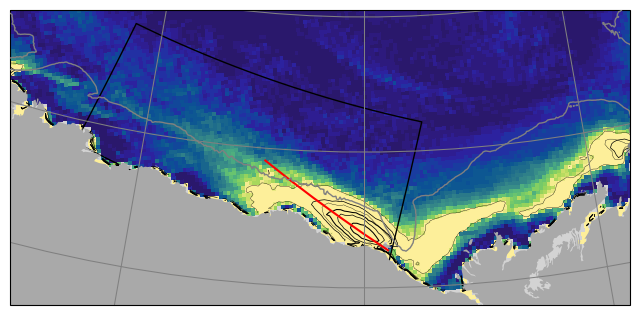

In [602]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-140)

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

# ax.set_ylim(-2800000,-500000)
# ax.set_xlim(-1500000,1500000)

ax.set_ylim(-2400000,-1900000)
ax.set_xlim(-600000,450000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)
geomap.gebco_bathymetry(ax, file_path='/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/GEBCO_2024/gebco_2024_n90.0_s55.0_w-180.0_e180.0.nc', 
                             crop_lat=(69, 73.5), crop_lon=(-170, -110), clat=5, clon=15, depth_shade=False, 
                             shade_zorder=0, depth_contours=True, contour_levels=[-100], 
                             contour_kwargs={'colors': 'gray', 'linewidths': 1, 'linestyles': 'solid', 'zorder': 100},
                             contour_labels=False, text_kwargs={'size': 10, 'color': 'gray', 'weight': 'normal', 'zorder': 100})

key = 'large'
ax.pcolormesh(sic_data[key]['xx'], sic_data[key]['yy'], ds60[f'{key}_open_freq'], 
              vmin=0, vmax=0.25, transform=sic['proj'], cmap=cmocean.cm.haline)

# ax.contour(sic_data[key]['xx'], sic_data[key]['yy'], sic_data[key]['open_freq'], 
#             levels=[0.25,0.5,0.75], colors=['k'], linewidths=[0.25,0.5,0.75], transform=sic['proj'])

ax.contour(sic_data[key]['xx'], sic_data[key]['yy'], ds60[f'{key}_open_freq'], 
            levels=[0.25,0.50,0.75], colors=['k'], linewidths=[0.25,0.50,0.75], transform=sic['proj'])


ax.contour(sic_data[key]['xx'], sic_data[key]['yy'], ds10[f'{key}_open_freq'], 
            levels=[0.25,0.50,0.75], colors=['k'], linewidths=[0.25,0.50,0.75], transform=sic['proj'])

# ax.pcolormesh(sic_data[key]['xx'], sic_data[key]['yy'], sic_data[key]['sic_mean'], 
#               vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic['proj'])

# ax.pcolormesh(sic_data[key]['xx'], sic_data[key]['yy'], sic_data['large']['open_freq']-sic_data['open']['open_freq'], 
#               vmin=-0.5, vmax=0.5, cmap=cmocean.cm.balance, transform=sic['proj'])

ax.add_geometries([reg_poly], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree())

ax.plot(reg_lons, reg_lats, c='r', transform=ccrs.PlateCarree())

line_kwargs = {'color':'gray', 'lw':0.75}
for lon in [-150,-140,-130]:
    ax.plot(np.full(10,lon), np.linspace(68,75,10), transform=ccrs.PlateCarree(), **line_kwargs)
for lat in [69, 71, 73]:
    ax.plot(np.linspace(-160,-110,30), np.full(30,lat), transform=ccrs.PlateCarree(), **line_kwargs)
    

41.820426550459494
-34.28250455547352


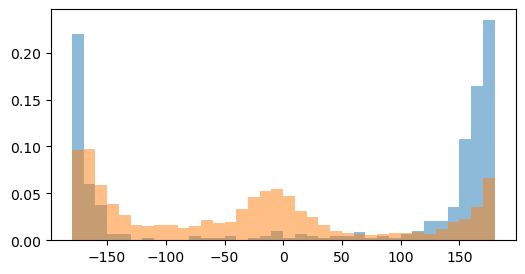

In [50]:

fig, ax = plt.subplots(figsize=(6,3))


var = 'a10'
bins = np.arange(-180,181,10)

x = compare['open'][var]
h = plotter.quick_hist(x, bin_edges = bins)
ax.bar(h['centers'], h['prob'], width = h['w'], alpha=0.5)
print(np.nanmean(x))

x = compare['comp'][var]
h = plotter.quick_hist(x, bin_edges = bins)
ax.bar(h['centers'], h['prob'], width = h['w'], alpha=0.5)
print(np.nanmean(x))

In [ ]:
# bin_edges = np.arange(-20,21,1)
# bin_edges = np.arange(0,20,1)
# bin_edges = np.arange(-35,0,2)
bin_edges = np.arange(-180,181,10)
bin_w = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + bin_w/2


compare['open']

cat = 'era'

x = daily_data[cat]['u'][daily_data['pol']['extent']>50]
t = daily_data[cat]['t2m'][daily_data['pol']['extent']>50]
s = daily_data[cat]['s'][daily_data['pol']['extent']>50]
y = daily_data[cat]['v'][daily_data['pol']['extent']>50]
a = daily_data[cat]['angle'][daily_data['pol']['extent']>50]
print('angle of mean:', vectors.vector_angle(np.nanmean(x),np.nanmean(y)).magnitude)

var = a

counts,bins=np.histogram(var, bins=bin_edges)
plt.bar(bin_centers, counts/len(var), width=0.9*bin_w, alpha=0.5)

x = daily_data[cat]['u'][daily_data['pol']['extent']<50]
t = daily_data[cat]['t2m'][daily_data['pol']['extent']<50]
s = daily_data[cat]['s'][daily_data['pol']['extent']<50]
y = daily_data[cat]['v'][daily_data['pol']['extent']<50]
a = daily_data[cat]['angle'][daily_data['pol']['extent']<50]
print('angle of mean:', vectors.vector_angle(np.nanmean(x),np.nanmean(y)).magnitude)


var = a

counts,bins=np.histogram(var, bins=bin_edges)
plt.bar(bin_centers, counts/len(var), width=0.9*bin_w, alpha=0.5)

angle of mean: 173.4028372143727
angle of mean: -143.23213679166747


<BarContainer object of 36 artists>

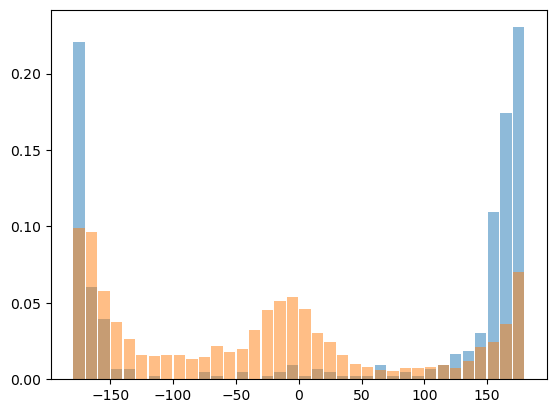

In [170]:
# bin_edges = np.arange(-20,21,1)
# bin_edges = np.arange(0,20,1)
# bin_edges = np.arange(-35,0,2)
bin_edges = np.arange(-180,181,10)
bin_w = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + bin_w/2

cat = 'era'

x = daily_data[cat]['u'][daily_data['pol']['extent']>50]
t = daily_data[cat]['t2m'][daily_data['pol']['extent']>50]
s = daily_data[cat]['s'][daily_data['pol']['extent']>50]
y = daily_data[cat]['v'][daily_data['pol']['extent']>50]
a = daily_data[cat]['angle'][daily_data['pol']['extent']>50]
print('angle of mean:', vectors.vector_angle(np.nanmean(x),np.nanmean(y)).magnitude)

var = a

counts,bins=np.histogram(var, bins=bin_edges)
plt.bar(bin_centers, counts/len(var), width=0.9*bin_w, alpha=0.5)

x = daily_data[cat]['u'][daily_data['pol']['extent']<50]
t = daily_data[cat]['t2m'][daily_data['pol']['extent']<50]
s = daily_data[cat]['s'][daily_data['pol']['extent']<50]
y = daily_data[cat]['v'][daily_data['pol']['extent']<50]
a = daily_data[cat]['angle'][daily_data['pol']['extent']<50]
print('angle of mean:', vectors.vector_angle(np.nanmean(x),np.nanmean(y)).magnitude)


var = a

counts,bins=np.histogram(var, bins=bin_edges)
plt.bar(bin_centers, counts/len(var), width=0.9*bin_w, alpha=0.5)


In [446]:
import timeseries.analyze as tanalyze

In [459]:
# original vector components
xp2 = daily_data['ppd']['u']
yp2 = daily_data['ppd']['v']

xp = xp2[np.isfinite(xp2)&np.isfinite(yp2)]
yp = yp2[np.isfinite(xp2)&np.isfinite(yp2)]

varell = tanalyze.variance_ellipses(xp,yp)
xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))


-0.3535498146763032


In [460]:
(varell['theta_m']*180/np.pi)+180

159.74308777141542

In [449]:
vectors.vector_angle(np.nanmean(xp), np.nanmean(yp))

<Quantity(170.788514, 'degree')>

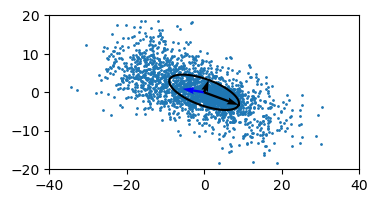

In [450]:
fig, ax = plt.subplots(figsize=(4,2))
ax.set_xlim(-20*2,20*2)
ax.set_ylim(-10*2,10*2)

thetas = np.linspace(-np.pi,np.pi,100)

# plt.plot(thetas*180/np.pi, s2(sxx, syy, sxy, thetas))

# plt.scatter(np.sqrt(R)*np.cos(thetas), 
#             np.sqrt(R)*np.sin(thetas))
# plt.scatter(xe, ye)
plt.scatter(xp-xp.mean(), yp-yp.mean(), s=1)
plt.plot(varell['xe'], varell['ye'], c='k')
plt.quiver(0,0,np.nanmean(xp), np.nanmean(yp), angles='xy', scale_units='xy', scale=1, color='b')

plt.quiver(0,0, 
           np.sqrt(varell['s11'])*np.cos(varell['theta_m']), 
           np.sqrt(varell['s11'])*np.sin(varell['theta_m']), angles='xy', scale_units='xy', scale=1, color='k')

plt.quiver(0,0, 
           np.sqrt(varell['s22'])*np.cos(varell['theta_m']+np.pi/2), 
           np.sqrt(varell['s22'])*np.sin(varell['theta_m']+np.pi/2), angles='xy', scale_units='xy', scale=1, color='k')

# plt.plot(thetas*180/np.pi, ds2dtheta(sxx, syy, sxy, thetas))
# plt.plot(thetas*180/np.pi, -4 * sxy * np.sin(2*(thetas)))

# plt.axvline(theta_m*180/np.pi)

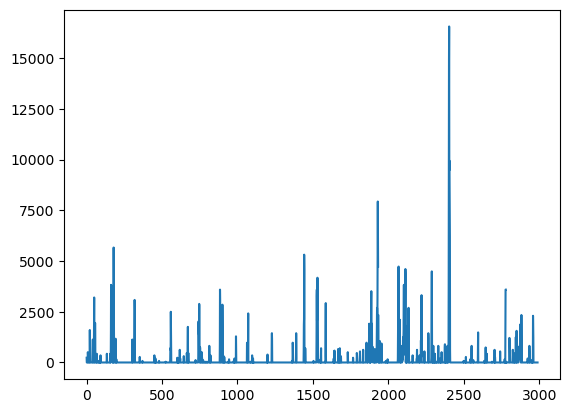

In [138]:
# plt.plot(daily_data['era']['angle'])
plt.plot(daily_data['pol']['extent'])

In [129]:
a

array([  19.5104022 ,  -13.8580853 , -167.70058823, ..., -132.22279531,
       -170.8590538 , -178.08628889])

In [124]:
len(x)/20

145.05

In [173]:
for key in daily_data.keys():
    daily_data[key]['time'] = pd.to_datetime(daily_data[key]['time']) 
    daily_data[key]['month'] = np.array([date.month for date in daily_data[key]['time']])
    daily_data[key]['year'] = np.array([date.year if date.month!=12 else date.year-1 for date in daily_data[key]['time']])

19.1
18.2
16.55
18.4
20.6


[Text(0, 0, '12'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4')]

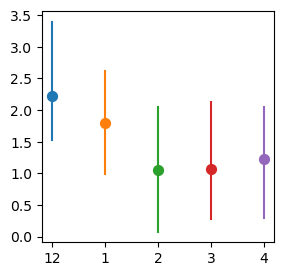

In [174]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.scatter(daily_data['era']['month'], daily_data['ppd']['ese'], s=1)

for mm, month in enumerate(months):
    
    mean_ppd_ese = np.nanmean(daily_data['ppd']['ese'][daily_data['ppd']['month']==month])
    mean_era_ese = np.nanmean(daily_data['era']['ese'][daily_data['era']['month']==month])
    
    
    cond = (daily_data['era']['ese'] > 0) & (daily_data['ppd']['month']==month)
    print(np.sum(cond)/len(years))
    monthly_wf = (daily_data['ppd']['ese']/daily_data['era']['ese'])[cond]
    
#     ax.scatter(mm, mean_ppd_ese/mean_era_ese, s=1)
    
    ax.scatter(mm, np.nanmedian(monthly_wf), s=50)
    
    ax.plot([mm,mm], [np.nanpercentile(monthly_wf, 25),
                      np.nanpercentile(monthly_wf, 75)], )

ax.set_xticks(range(len(months)))
ax.set_xticklabels(months)

# ax.scatter(daily_data['ppd']['ese'], daily_data['era']['t2m'], s=1)
# ax.scatter(daily_data['ppd']['ese'], daily_data['pol']['extent'], s=5)

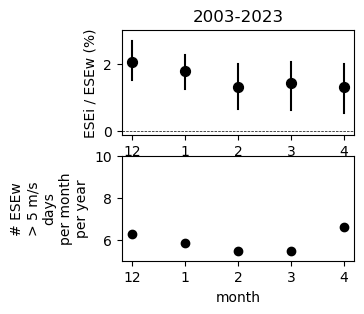

In [175]:
fig, axs = plt.subplots(2,1,figsize=(3,3))

# ax.scatter(daily_data['era']['month'], daily_data['ppd']['ese'], s=1)

month_colors =['k', 'b', 'dodgerblue', 'lightcoral', 'r']

for mm, month in enumerate(months):

#         if month == 4:
    cond = (daily_data['ppd']['month']==month)# & (daily_data['ppd']['month']==month)
    cond = (cond) & (daily_data['era']['ese'] > 5)

    ax=axs[1]
    
    monthly_days_per_year = np.sum(daily_data['ppd']['month']==month) / len(years[:-2])
    ax.scatter(mm, np.sum(cond)/monthly_days_per_year, c='k')
#     ax.scatter(year, np.sum(cond)/len(cond))
#     mean_ppd_ese = np.nanmean(daily_data['ppd']['s'][cond])
#     mean_era_ese = np.nanmean(daily_data['era']['s'][cond])

    annual_wf = (daily_data['ppd']['ese']/daily_data['era']['s'])[cond]

#     ax.scatter(mm, mean_ppd_ese/mean_era_ese, s=1)

    ax=axs[0]
    dx = (mm - 2.5)/10
    ax.scatter(mm, np.nanmedian(annual_wf), s=50,  c='k')#c=month_colors[mm])

    ax.plot([mm, mm], [np.nanpercentile(annual_wf, 25),
                      np.nanpercentile(annual_wf, 75)],  c='k')#c=month_colors[mm])

            
ax.set_title('2003-2023')

ax = axs[0]
ax.set_ylim(-0.1,3)
ax.axhline(0,c='k', lw=0.5, ls='dashed')
ax.set_ylabel('ESEi / ESEw (%)')

ax.set_xticks(np.arange(len(months)))
ax.set_xticklabels(months)

ax = axs[1]
ax.set_ylim(5,10)
# ax.axhline(0,c='k', lw=0.5, ls='dashed')
# ax.set_yticks([0,30,60,90,120]);
ax.set_ylabel('# ESEw\n> 5 m/s\ndays\nper month\nper year')


ax.set_xticks(np.arange(len(months)))
ax.set_xticklabels(months)
ax.set_xlabel('month')
    
fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight')

# ax.set_xticks(range(len(months)))
# ax.set_xticklabels(months)

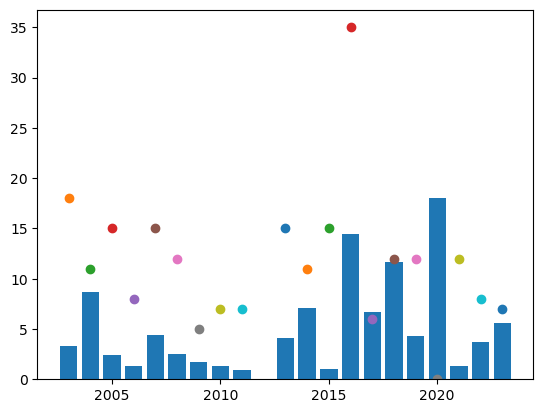

In [176]:
fig, ax = plt.subplots()
ax.bar(years, annual_data['cum_polynya_extent']/5000, )

for year in years:
    
    cond = (daily_data['era']['year']==year) #& (daily_data['ppd']['month']==1)

    ax.scatter(year,np.nansum(daily_data['era']['ese'][cond] > 10))
    

In [1277]:
cond

array([False, False, False, ..., False, False, False])

In [1161]:
speed_thresh = (compare['event']['speed'] > 5) 
angle_thresh = (compare['event']['angles'].magnitude > 135) + (compare['event']['angles'].magnitude < -170)

np.nansum(speed_thresh&angle_thresh) / np.sum(np.isfinite(compare['event']['speed']))

0.7876395317179418

In [1162]:
speed_thresh = (compare['other']['speed'] > 5) 
angle_thresh = (compare['other']['angles'].magnitude > 135) + (compare['other']['angles'].magnitude < -170)

np.nansum(speed_thresh&angle_thresh) / np.sum(np.isfinite(compare['other']['speed']))

0.1495519457901903

In [1163]:
0.757725587144623/0.1426732797589151

5.310914478345239

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_7738/2004616948.py:6: RuntimeWarning: invalid value encountered in divide
  plt.bar(bin_centers, event_vals/len(compare['event']['angles_ppd']), width=db, align='center',alpha=0.5)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_7738/2004616948.py:9: RuntimeWarning: invalid value encountered in divide
  plt.bar(bin_centers, other_vals/len(compare['other']['angles_ppd']), width=db, align='center',alpha=0.5)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_7738/2004616948.py:12: RuntimeWarning: invalid value encountered in divide
  thresh = (event_vals*db/len(compare['event']['angles_ppd'])) > 0.05
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_7738/2004616948.py:13: RuntimeWarning: invalid value encountered in divide
  plt.scatter(bin_centers[thresh], (event_vals/len(compare['event']['angles_ppd']))[thresh], marker='*', c='k')


[]
[]


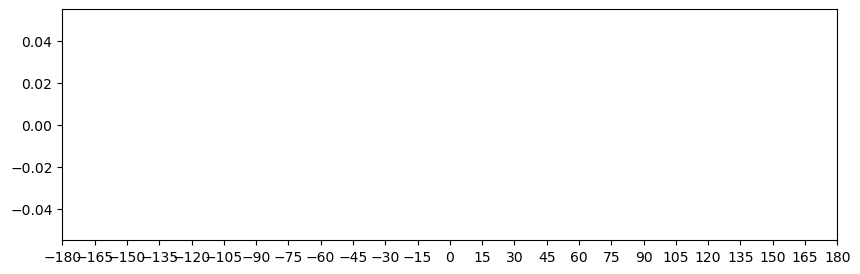

In [21]:

fig, ax = plt.subplots(figsize=(10,3))
bin_edges = np.arange(-180, 181, 5)
db = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + db/2
event_vals, event_edges = np.histogram(compare['event']['angles_ppd'].magnitude, bins = bin_edges, density=False)
plt.bar(bin_centers, event_vals/len(compare['event']['angles_ppd']), width=db, align='center',alpha=0.5)

other_vals, other_edges = np.histogram(compare['other']['angles_ppd'].magnitude, bins = bin_edges, density=False)
plt.bar(bin_centers, other_vals/len(compare['other']['angles_ppd']), width=db, align='center',alpha=0.5)


thresh = (event_vals*db/len(compare['event']['angles_ppd'])) > 0.05
plt.scatter(bin_centers[thresh], (event_vals/len(compare['event']['angles_ppd']))[thresh], marker='*', c='k')
print(bin_centers[thresh])
print(bin_edges[:-1][thresh])

# plt.hist(compare['other']['angles'], bins=bins, alpha=0.5, density=True)
ax.set_xticks(bin_edges[::3]);

In [1175]:
bin_centers[np.argmax(event_vals)]

162.5

In [1111]:
np.sum((event_vals)[thresh])/len(compare['event']['angles_ppd'])

0.8876889848812095

[ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32.]
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]


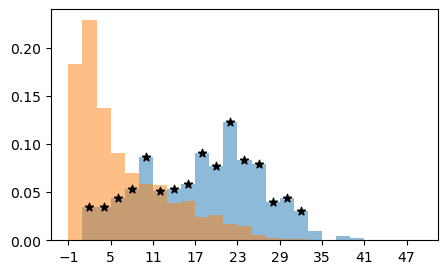

In [1165]:

fig, ax = plt.subplots(figsize=(5,3))
bin_edges = np.arange(-1, 50, 2)
db = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + db/2
event_vals, event_edges = np.histogram(compare['event']['speed_ppd'], bins = bin_edges, density=False)
plt.bar(bin_centers, event_vals/len(compare['event']['speed_ppd']), width=db, align='center',alpha=0.5)

other_vals, other_edges = np.histogram(compare['other']['speed_ppd'], bins = bin_edges, density=False)
plt.bar(bin_centers, other_vals/len(compare['other']['speed_ppd']), width=db, align='center',alpha=0.5)


thresh = (event_vals*db/len(compare['event']['speed_ppd'])) > 0.05
plt.scatter(bin_centers[thresh], (event_vals/len(compare['event']['speed_ppd']))[thresh], marker='*', c='k')
print(bin_centers[thresh])
print(bin_edges[:-1][thresh])

# plt.hist(compare['other']['angles'], bins=bins, alpha=0.5, density=True)
ax.set_xticks(bin_edges[::3]);

4.711433790735862
[ 5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5]
[ 5  6  7  8  9 10 11 12 13]


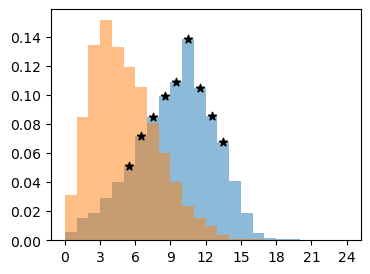

In [1166]:



fig, ax = plt.subplots(figsize=(4,3))
bin_edges = np.arange(0,25,1)
db = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + db/2
event_vals, event_edges = np.histogram(compare['event']['speed'], bins = bin_edges, density=False)
plt.bar(bin_centers, event_vals/len(compare['event']['speed']), width=db, align='center',alpha=0.5)

other_vals, other_edges = np.histogram(compare['other']['speed'], bins = bin_edges, density=False)
plt.bar(bin_centers, other_vals/len(compare['other']['speed']), width=db, align='center',alpha=0.5)
print(np.nanmedian(compare['other']['speed']))
# plt.bar(bin_centers, event_vals/other_vals, width=db, align='center',alpha=0.5)


# thresh = (event_vals/other_vals) > 1.
# plt.scatter(bin_centers[thresh], (event_vals/other_vals)[thresh], marker='*', c='k')
# print(bin_centers[thresh])
# print(bin_edges[:-1][thresh])

thresh = (event_vals*db)/len(compare['event']['speed']) > 0.05
plt.scatter(bin_centers[thresh], (event_vals/len(compare['event']['speed']))[thresh], marker='*', c='k')
print(bin_centers[thresh])
print(bin_edges[:-1][thresh])

# plt.hist(compare['other']['angles'], bins=bins, alpha=0.5, density=True)
ax.set_xticks(bin_edges[::3]);

In [1046]:
np.sum(compare['event']['speed'] > 5) / len(compare['event']['speed'])

0.8832906119833387

In [1047]:
np.sum(compare['other']['speed'] > 5) / len(compare['other']['speed'])

0.4604254021498818

In [1048]:
np.nanpercentile(compare['other']['speed'], 90)

8.924008805412962

[-177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5  107.5  122.5  127.5
  132.5  137.5  142.5  147.5  152.5  157.5  162.5  167.5  172.5  177.5]
[-180 -175 -170 -165 -160 -155 -150  105  120  125  130  135  140  145
  150  155  160  165  170  175]


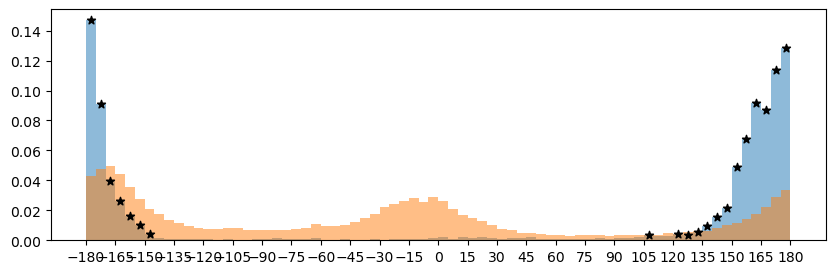

In [1176]:



fig, ax = plt.subplots(figsize=(10,3))
bin_edges = np.arange(-180, 181, 5)
db = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + db/2
event_vals, event_edges = np.histogram(compare['event']['angles'].magnitude, bins = bin_edges, density=False)
plt.bar(bin_centers, event_vals/len(compare['event']['angles']), width=db, align='center',alpha=0.5)

other_vals, other_edges = np.histogram(compare['other']['angles'].magnitude, bins = bin_edges, density=False)
plt.bar(bin_centers, other_vals/len(compare['other']['angles']), width=db, align='center',alpha=0.5)

# plt.bar(bin_centers, event_vals/other_vals, width=db, align='center',alpha=0.5)


# thresh = (event_vals/other_vals) > 1.
# plt.scatter(bin_centers[thresh], (event_vals/other_vals)[thresh], marker='*', c='k')
# print(bin_centers[thresh])
# print(bin_edges[:-1][thresh])

thresh = (event_vals/len(event_vals)) > 0.5
plt.scatter(bin_centers[thresh], (event_vals/len(compare['event']['angles']))[thresh], marker='*', c='k')
print(bin_centers[thresh])
print(bin_edges[:-1][thresh])

# plt.hist(compare['other']['angles'], bins=bins, alpha=0.5, density=True)
ax.set_xticks(bin_edges[::3]);

In [1177]:
bin_centers[np.argmax(event_vals)]

-177.5

In [1026]:
np.sum((event_vals/len(event_vals))[thresh])

85.98611111111111

In [1051]:
total_wind_hours = 0

for mm, month in enumerate(months):
    for year in years:
        total_wind_hours += wind_counts[month][year]
                                  

In [1052]:
total_wind_hours

26892

In [1053]:
bin_edges = np.arange(0.5,24*30,12)
db = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + db/2
bin_vals, xx = np.histogram(wind_durations, bins = bin_edges, density=False)

In [1054]:
np.sum((bin_vals * bin_centers) )/total_wind_hours

1.0031607913134017

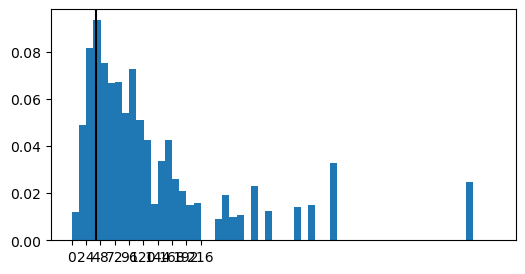

In [1055]:
fig, ax = plt.subplots(figsize=(6,3))

ax.set_xticks(np.arange(0,24*10,24))

ax.bar(bin_edges[:-1], (bin_vals * bin_centers) / total_wind_hours, width=db, align='edge')

# ax.bar(bin_edges[:-1], bin_vals, width=db, align='edge')

ax.axvline(np.nanpercentile(wind_durations,50), c='k')

In [706]:
len(bin_edges[:-1][thresh]) / len(bin_edges[:-1])

0.19444444444444445

In [621]:
anlgs < -170

array([-31, -31, -31, ..., 118, 118, 119])

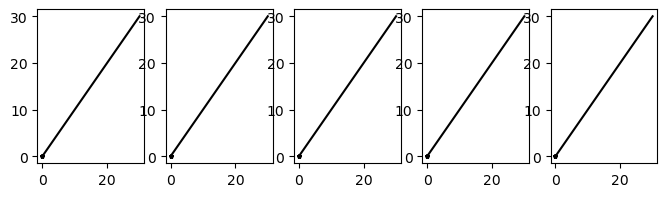

In [166]:
fig, axs = plt.subplots(1, len(months), figsize=(8,2))

month_shapes = ['*', '*', 's', 'o', 'o']
month_colors = ['b', 'dodgerblue', 'gray', 'lightcoral', 'None']
edge_colors = ['None', 'None', 'k', 'None', 'k']



for mm, month in enumerate(months):
    
    ax = axs[mm]
    ax.plot([0,30], [0,30], c='k')
    
    for year in years:
        

        ax.scatter(wind_counts[month][year]/24, 
                   polynya_counts[month][year], 
                   s=5, c='k', marker='*')
#                    marker=month_shapes[mm], 
#                    facecolor=month_colors[mm],
#                   edgecolor=edge_colors[mm])

[Text(0, 0, '12'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4')]

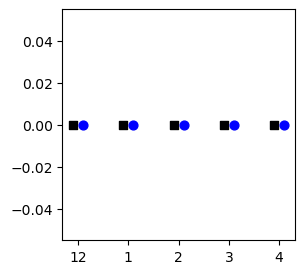

In [177]:
fig, ax = plt.subplots(figsize=(3,3))

for mm, month in enumerate(months):
    
    monthly_winds = np.array([])
    for year in years:
        monthly_winds = np.append(monthly_winds, wind_counts[month][year]/24)
    
    monthly_polynyas = np.array([])
    for year in years:
        monthly_polynyas = np.append(monthly_polynyas, polynya_counts[month][year])
    
    dx = -0.1
    ax.scatter(np.full(len(years), mm+dx), monthly_winds, c='lightgray', s=1)
    color = 'k'
    ax.scatter(mm+dx, np.nanpercentile(monthly_winds, 50), c=color, marker='s', s=40)
    ax.plot([mm+dx,mm+dx], [np.nanpercentile(monthly_winds, 25),np.nanpercentile(monthly_winds, 75)], c=color)
    
    dx = 0.1
    color = 'blue'
    ax.scatter(np.full(len(years), mm+dx), monthly_polynyas, c='dodgerblue', s=1)
    ax.scatter(mm+dx, np.nanpercentile(monthly_polynyas, 50),  c=color, marker='o', s=40)
    ax.plot([mm+dx,mm+dx], [np.nanpercentile(monthly_polynyas, 25),np.nanpercentile(monthly_polynyas, 75)], c=color)
    

ax.set_xticks(range(len(months)))
ax.set_xticklabels(months)

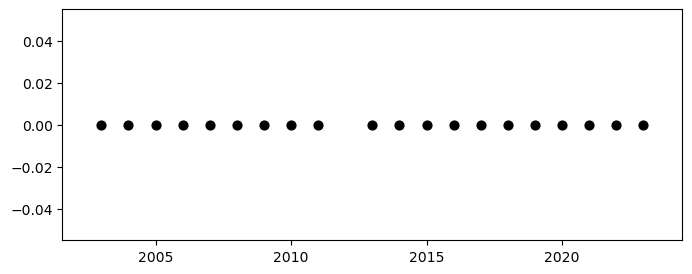

In [178]:
fig, ax = plt.subplots(figsize=(8,3))

for yy, year in enumerate(years):
    
    annual_winds = np.array([])
    for month in months:
        annual_winds = np.append(annual_winds, wind_counts[month][year]/24)
    
    annual_polynyas = np.array([])
    for month in months:
        annual_polynyas = np.append(annual_polynyas, polynya_counts[month][year])
    
#     dx = -0.1
#     ax.scatter(np.full(len(months), year+dx), annual_winds, c='lightgray', s=1)
#     color = 'k'
#     ax.scatter(year+dx, np.nanpercentile(annual_winds, 50), c=color, marker='s', s=40)
#     ax.plot([year+dx,year+dx], [np.nanpercentile(annual_winds, 25),np.nanpercentile(annual_winds, 75)], c=color)
    
#     dx = 0.1
#     color = 'blue'
#     ax.scatter(np.full(len(months), year+dx), annual_polynyas, c='dodgerblue', s=1)
#     ax.scatter(year+dx, np.nanpercentile(annual_polynyas, 50),  c=color, marker='o', s=40)
#     ax.plot([year+dx,year+dx], [np.nanpercentile(annual_polynyas, 25),np.nanpercentile(annual_polynyas, 75)], c=color)
    

    dx = -0.1
    color='k'
    ax.bar(year, np.sum(annual_winds),   color='darkgray')

    dx = 0.1
    color = 'blue'
    ax.scatter(year, np.sum(annual_polynyas),   c='k', marker='o', s=40)

# ax.set_xticks(range(len(months)))
# ax.set_xticklabels(months)

In [948]:
from scipy import stats


2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
0.6461208371730984
0.41747213622926554


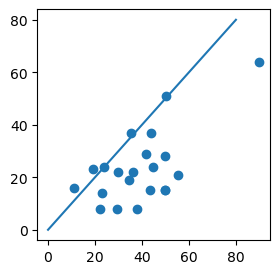

In [1117]:
fig, ax = plt.subplots(figsize=(3,3))

ax.plot([0,80], [0,80])

x = np.array([])
y = np.array([])
for yy, year in enumerate(years[:]):
    
    print(year)
    
    annual_winds = np.array([])
    for month in months:
        annual_winds = np.append(annual_winds, long_wind_counts[month][year]/24)
    
    annual_polynyas = np.array([])
    for month in months:
        annual_polynyas = np.append(annual_polynyas, polynya_counts[month][year])
    
    
    x = np.append(x, np.sum(annual_winds))
    y = np.append(y, np.sum(annual_polynyas))
    
ax.scatter(x,y)

res = stats.linregress(x, y)

print(res.rvalue)
print(res.rvalue**2)

In [927]:
annual_winds

array([13.54166667, 10.375     ,  9.70833333, 11.58333333,  0.        ])

### Create maps of data

In [62]:
# # start dict to store event times
# cats = ['start', 'final', 'all']

# seq_times = {}

# for cat in cats:
#     seq_times[cat] = np.array([])
    
# for ss in all_seqs:
#     seq_times['all'] = np.append(seq_times['all'], all_seqs[ss])
#     seq_times['start'] = np.append(seq_times['start'], all_seqs[ss][0])
#     seq_times['final'] = np.append(seq_times['final'], all_seqs[ss][-1])



In [198]:

maps = {}

era_vars = ['u10', 'v10', 's10', 'msl', 't2m']
ppd_vars = ['e', 'n', 's',]
        
date = datetime(2020,1,1)
dse = open_daily_winds(date.year, era_lat_range, era_lon_range, time_range = date)
ds2 = open_daily_t2m(date.year, era_lat_range, era_lon_range, time_range = date)
drift = open_daily_drift(date.year, era_lat_range, era_lon_range, time_range = date)

for cat in compare.keys():
    maps[cat] = {}
    for var in era_vars:
        maps[cat][var] = {}
        if str(var) in ['s10']:
            maps[cat][var]['sum'] = np.zeros(dse['u10'].values.shape)
            maps[cat][var]['N'] = np.zeros(dse['u10'].values.shape)
        elif str(var) in ['t2m']:
            maps[cat][var]['sum'] = np.zeros(ds2['t2m'].values.shape)
            maps[cat][var]['N'] = np.zeros(ds2['t2m'].values.shape)
        else:
            maps[cat][var]['sum'] = np.zeros(dse[var].values.shape)
            maps[cat][var]['N'] = np.zeros(dse[var].values.shape)
    for var in ppd_vars:
        maps[cat][var] = {}
        maps[cat][var]['sum'] = np.zeros(drift[var].shape)
        maps[cat][var]['N'] = np.zeros(drift[var].shape)
        
            
for dd, date in enumerate(all_consol_dates):
    
    if dd % 100 == 0:
        print(f'{dd}/{len(all_consol_dates)}')
    
    date = pd.to_datetime(date)
    dse = open_daily_winds(date.year, era_lat_range, era_lon_range, time_range = date)
    ds2 = open_daily_t2m(date.year, era_lat_range, era_lon_range, time_range = date)
    drift = open_daily_drift(date.year, era_lat_range, era_lon_range, time_range = date)

    for cat in compare.keys():
        for var in era_vars:
            if date in compare[cat]['time']:
                if str(var) == 's10':
                    maps[cat][var]['sum'] += np.sqrt(dse['u10'].values**2+dse['v10'].values**2)
                    maps[cat][var]['N'] += np.isfinite(dse['u10'].values)
                elif str(var) == 't2m':
                    maps[cat][var]['sum'] += ds2[var].values-273.15
                    maps[cat][var]['N'] += np.isfinite(ds2[var].values)
                else:
                    maps[cat][var]['sum'] += dse[var].values
                    maps[cat][var]['N'] += np.isfinite(dse[var].values)
        for var in ppd_vars:
            if date in compare[cat]['time']:
                maps[cat][var]['sum'] += drift[var]
                maps[cat][var]['N'] += np.isfinite(drift[var])
                
for cat in compare.keys():     
    for var in era_vars:
        maps[cat][var]['mean'] = maps[cat][var]['sum'] / maps[cat][var]['N']
    maps[cat]['dc'] = np.sqrt(maps[cat]['u10']['mean']**2+maps[cat]['v10']['mean']**2) / maps[cat]['s10']['mean']
    
    for var in ppd_vars:
        maps[cat][var]['mean'] = maps[cat][var]['sum'] / maps[cat][var]['N']

0/2990



KeyboardInterrupt



In [200]:
for cat in compare.keys():     
    for var in era_vars:
        maps[cat][var]['mean'] = maps[cat][var]['sum'] / maps[cat][var]['N']
    maps[cat]['dc'] = np.sqrt(maps[cat]['u10']['mean']**2+maps[cat]['v10']['mean']**2) / maps[cat]['s10']['mean']
    
    for var in ppd_vars:
        maps[cat][var]['mean'] = maps[cat][var]['sum'] / maps[cat][var]['N']

In [199]:
dd

80

In [231]:
# dsm = xr.open_dataset('../data/forcing/dailymaps_era_v0.nc')


# bg_t = dsm.t2m.mean(['month', 'year'])
# bg_u10 = dsm.u10.mean(['month', 'year'])
# bg_v10 = dsm.v10.mean(['month', 'year'])
# bg_s = dsm.s10.mean(['month', 'year'])
# bg_dc = np.sqrt(bg_v**2 + bg_v**2) / bg_s


# cat = 'open'
# du = maps[cat]['u10']['mean'] - bg_u10
# dv = maps[cat]['v10']['mean'] - bg_v10
# total_vec_anom = np.sqrt(du**2+dv**2)

# angles = vectors.vector_angle(maps[cat]['u10']['mean'], maps[cat]['v10']['mean'])
# angles[angles<0]+=360

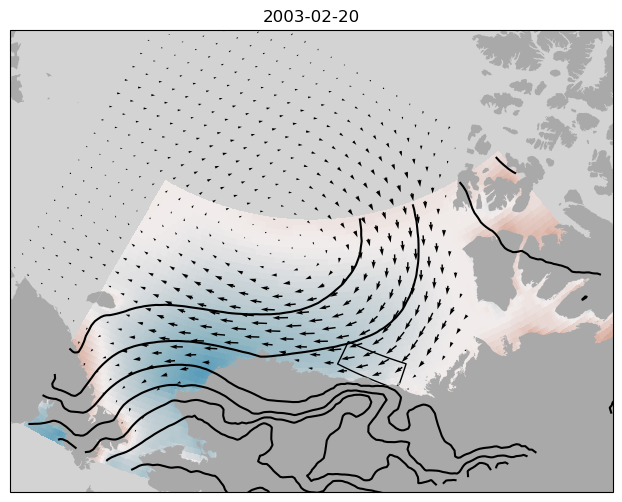

In [230]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

ax.set_ylim(-2800000,-500000)
ax.set_xlim(-1500000,1500000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)
ax.set_title(date.date())

# ax.pcolormesh(dse.longitude, dse.latitude, maps['all']['v10']['mean'] - bg_v, vmin=-10,vmax=10, 
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.pcolormesh(dse.longitude, dse.latitude, maps['start']['s10']['mean'] - bg_s, vmin=-8,vmax=8, 
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.pcolormesh(dse.longitude, dse.latitude, total_vec_anom, vmin=5,vmax=10, 
#               cmap=cmocean.cm.haline, transform=ccrs.PlateCarree())



# ax.pcolormesh(dse.longitude, dse.latitude, bg_t, vmin=-40,vmax=-10, 
#               cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())

# ax.contour(dse.longitude, dse.latitude, maps['all']['dc'], levels=[0.85,0.875,0.9,0.95, 1],
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())



# ax.pcolormesh(dse.longitude, dse.latitude, maps['large']['u10']['mean'], vmin=-10, vmax=10,
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


cat = 'comp'

ax.pcolormesh(dse.longitude, dse.latitude, maps[cat]['u10']['mean'], vmin=-15, vmax=15,
              cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

ax.contour(dse.longitude, dse.latitude, maps[cat]['msl']['mean']/100,
           levels=np.arange(980,1060,2), colors=['k'], transform=ccrs.PlateCarree())


U, V = geomap.fix_cartopy_vectors( maps[cat]['e']['mean'], maps[cat]['n']['mean'],drift['lat'] )
sp = 3
ax.quiver(drift['lon'][::sp,::sp], drift['lat'][::sp,::sp], U[::sp,::sp], V[::sp,::sp], 
           angles='xy', scale_units='xy', scale=0.0001, color='k', transform=ccrs.PlateCarree() )


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree())
# ax.add_geometries([reg_poly2], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree(), zorder=100)


In [225]:
drift['lat'].shape

(100, 90)

In [116]:
maps['open']['u10']['mean']

array([[-6.33512393, -6.36056706, -6.3883199 , ..., -1.21951695,
        -1.16989599, -1.11996235],
       [-6.39658295, -6.41467033, -6.4327566 , ..., -1.43588181,
        -1.3507128 , -1.26545125],
       [-6.37686807, -6.40158582, -6.4272047 , ..., -1.55807365,
        -1.5720865 , -1.58564462],
       ...,
       [-2.24591205, -2.40830296, -2.49977137, ..., -2.35796946,
        -2.3575059 , -2.35848543],
       [-3.14440928, -3.02458917, -2.96083463, ..., -3.04862902,
        -3.0600121 , -3.0676348 ],
       [-3.62648185, -3.50531121, -3.4517708 , ..., -2.99433956,
        -3.10442169, -3.26097929]])

In [97]:
maps['inc']['u10']['mean']

array([[-7.78713138, -7.81529995, -7.84647426, ..., -1.05275406,
        -0.9856221 , -0.91814326],
       [-7.92723005, -7.94543972, -7.9635781 , ..., -1.30348433,
        -1.1972822 , -1.09091508],
       [-7.97375547, -8.0004393 , -8.02819538, ..., -1.47589582,
        -1.47406795, -1.47170381],
       ...,
       [-2.88182985, -3.04569132, -3.11768526, ..., -2.57410093,
        -2.56759202, -2.57202763],
       [-4.0380519 , -3.84992351, -3.71678929, ..., -3.23536674,
        -3.24158588, -3.25289817],
       [-4.8237599 , -4.63354461, -4.50517245, ..., -3.21208103,
        -3.30128395, -3.44066225]])

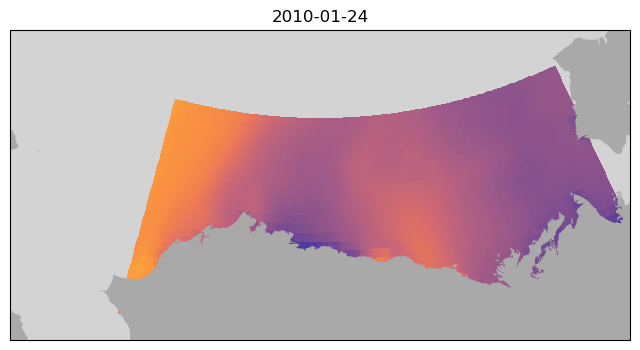

In [78]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-1000000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)
ax.set_title(date.date())


ax.pcolormesh(ds2.longitude, ds2.latitude, ds2.t2m-273.15, vmin=-40,vmax=0, 
              cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())

In [11]:
GROUPS = {}
GROUPS['era'] = ['u10', 'v10', 'msl', 't2m', 's10']
GROUPS['ppd'] = ['e', 'n','s']
months = [12, 1, 2, 3, 4]

In [12]:

all_vals = {}

for key in ['era', 'ppd']:
    
    filename = f'../data/forcing/regional_{key}_v0.nc'
    ds = xr.open_dataset(filename)
    all_time = pd.to_datetime(ds.date.values.flatten())

    for group in GROUPS[key]:
        all_vals[group] = ds[group].values.flatten()


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [13]:


# start dict to store event times
cats = ['start', 'final', 'all']

seq_times = {}

for cat in cats:
    seq_times[cat] = np.array([])
    
for ss in all_seqs:
    seq_times['all'] = np.append(seq_times['all'], all_seqs[ss])
    seq_times['start'] = np.append(seq_times['start'], all_seqs[ss][0])
    seq_times['final'] = np.append(seq_times['final'], all_seqs[ss][-1])


# start empty arrays to store date
event_vals = {}
non_event_vals = {}

for cat in cats:
    event_vals[cat] = {}
    for key in ['era', 'ppd']:
        for group in GROUPS[key]:
            event_vals[cat][group] = np.array([])
            non_event_vals[group] = np.array([])

            
# grab values at event times           
for tt, time in enumerate(all_time):

    if time not in seq_times['all']:
        for key in ['era', 'ppd']:
            for group in GROUPS[key]:
                non_event_vals[group] = np.append(non_event_vals[group], all_vals[group][tt])
        
    for cat in cats:
        
        # look for date matches
        if time in seq_times[cat]:
#         date_ind = np.where(seq_times[cat] == time)[0]
        
        # if matched, add values
#         if len(date_ind) == 1:
            for key in ['era', 'ppd']:
                for group in GROUPS[key]:
                    event_vals[cat][group] = np.append(event_vals[cat][group], all_vals[group][tt])


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


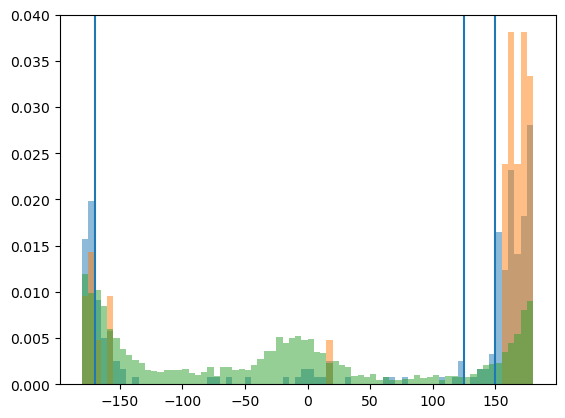

In [84]:

fig, ax = plt.subplots()

# bins = np.arange(-40,40)

# ax.hist(event_vals['all']['e'], bins=bins, alpha=0.5, density=True)
# ax.hist(event_vals['start']['e'], bins=bins, alpha=0.5, density=True)

# ax.hist(event_vals['all']['n'], bins=bins, alpha=0.5, density=True)
# ax.hist(event_vals['all']['e'], bins=bins, alpha=0.5, density=True)

key = 'ppd'
ds = xr.open_dataset(f'../data/forcing/regional_{key}_v0.nc') 
bins = np.arange(-180,181,5)
angles = vectors.vector_angle(event_vals['all']['u10'], event_vals['all']['v10'])
ax.hist(angles, bins=bins, alpha=0.5, density=True);

angles = vectors.vector_angle(event_vals['start']['u10'], event_vals['start']['v10'])
ax.hist(angles, bins=bins, alpha=0.5, density=True);

angles = vectors.vector_angle(non_event_vals['u10'], non_event_vals['v10'])
ax.hist(angles, bins=bins, alpha=0.5, density=True);

ax.axvline(125)
ax.axvline(150)
ax.axvline(-170)

# bins = np.arange(-180,181,5)
# angles = vectors.vector_angle(event_vals['all']['u10'], event_vals['all']['v10'])
# ax.hist(angles, bins=bins, alpha=0.5, density=True);

# angles = vectors.vector_angle(non_event_vals['u10'], non_event_vals['v10'])
# ax.hist(angles, bins=bins, alpha=0.5, density=True);

In [15]:


def grab_regiondata_bytime(dates):
    
    data = {}
    data['time'] = dates
    
    
    key = 'era'
    ds = xr.open_dataset(f'../data/forcing/regional_{key}_v0.nc')  
    cats = ['u10', 'v10', 's10', 'msl', 't2m']
    
    for cat in cats:
        data[cat] = np.array([])
    
    for date in dates:
        month = date.month
        if month == 12:
            YEAR = date.year+1
        else:
            YEAR = date.year
        monthlength = calendar.monthrange(YEAR, month)[-1]
        day = date.day
        for cat in cats:
            data[cat] = np.append(data[cat], ds[cat].sel(year = YEAR, month = date.month, day = day))
        
    key = 'ppd'
    ds = xr.open_dataset(f'../data/forcing/regional_{key}_v0.nc')  
    cats = ['e', 'n', 's']
    
    for cat in cats:
        data[cat] = np.array([])
    
    for date in dates:
        month = date.month
        if month == 12:
            YEAR = date.year+1
        else:
            YEAR = date.year
        monthlength = calendar.monthrange(YEAR, month)[-1]
        day = date.day
        for cat in cats:
            data[cat] = np.append(data[cat], ds[cat].sel(year = YEAR, month = date.month, day = day))
        
    return data

In [584]:
time_range

slice(datetime.datetime(2013, 12, 1, 0, 0), datetime.datetime(2014, 4, 30, 0, 0), None)

In [237]:



year = 2023

DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic15_v5.nc')
time_range = slice(datetime(year-1,12,1), datetime(year,4,30))
DS = DS.sel(time = time_range)
DS['length'] = DS.l_per95 - DS.l_per5
DS['width'] = DS.w_per95 - DS.w_per5

dates = pd.date_range(time_range.start, time_range.stop)
regdata = grab_regiondata_bytime(dates)

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [238]:
len(regdata['n'])

151

In [239]:


# u = regdata['e']*units('cm/s').to('km/day')
# v = regdata['n']*units('cm/s').to('km/day')
# angles = vectors.vector_angle(u, v)
# along = vectors.comp_along_theta(u, v, (60+90)*units('degree')) 
# open_cond = (angles > 135 * units('degree')) + (angles < -170 * units('degree')) 

u = 0.03*regdata['u10']*units('m/s')
v = 0.03*regdata['v10']*units('m/s')
angles = vectors.vector_angle(u, v)
along = vectors.comp_along_theta(u, v, (25+60+90)*units('degree')) * units('m/s').to('km/day')
wind_speed = np.sqrt((regdata['u10'])**2+(regdata['v10'])**2)
open_angle = (angles > 145 * units('degree')) + (angles < -175 * units('degree')) 
open_cond = open_angle & (wind_speed > 3)


event_times = regdata['time']
consecutive_open = tseries.dates_to_sequences(event_times[open_cond], dt_max = 1 * units('day'))

cum_open = np.zeros(len(along))
for cc in consecutive_open:
    start = np.where(event_times == consecutive_open[cc][0])[0][0]
    final = np.where(event_times == consecutive_open[cc][-1])[0][0]
    cum_open[start:final+1] = np.cumsum(along[start:final+1])


Help on function running_mean in module timeseries.adjust:

running_mean(series, length=3, center=False, address_nans=False)
    Function to calculate running mean of a series (assumes evenly spaced data).

    INPUT:
    - series: (M x 1) array of data to calculate running mean
    - length: length of running mean window
        (either one-sided (window=length+1), or one side of two-sided if center=True (window=2*length + 1))
    - center: if True, calculate two-sided running mean
    - address_nans: if True, address nans in data by taking mean of non-nan values in window
        (else carry any nans to final data)

    OUTPUT:
    - running_mean: (M x 1) array of running mean values

    Latest recorded update:
    01-30-2025



In [240]:


# fig, ax = plt.subplots(figsize=(3,3))

# ax.set_xlim(-1,60)
# ax.set_ylim(-1,60)

# ax.plot(ax.get_xlim(), ax.get_ylim(), lw=0.5, c='k', zorder=-1)

# # ax.bar(years, num_wind_events)
# # ax.scatter(years, num_poly_events, c='k', marker='*')

# ax.scatter(num_wind_events, num_poly_events, c='k', marker='*')

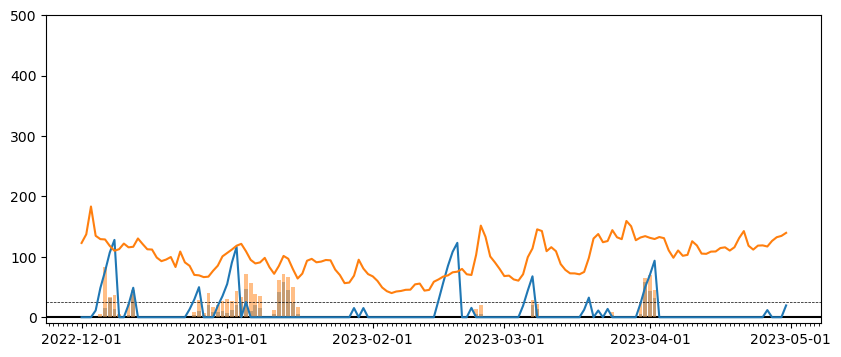

In [241]:


fig, ax = plt.subplots(figsize=(10,4))
ax.set_ylim(-10,500)

plt.axhline(1000/40, c='k', lw=0.5, ls='dashed')

plt.bar(DS.time, DS.extent.values/40, alpha=0.5)
plt.bar(DS.time, DS.length.values, alpha=0.5)
# plt.bar(DS.time, DS.polynya_extent.values / 50)

# plt.plot(event_times, open_along, marker='.')
# plt.plot(event_times, cum_open2, marker='.')
plt.plot(event_times, cum_open)
# plt.plot(event_times, u, marker='.')
# plt.plot(event_times, v, marker='.')


ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.axhline(0, c='k', zorder=-1)


# ax.plot(event_times, -20*regdata['u10'])
# ax.plot(event_times, 20*regdata['v10'])

ax.plot(event_times, 5*(regdata['t2m'] + 40))
# plt.bar(DS.time, DS.extent.values/DS.width.values, alpha=0.5)

In [190]:
cum_open2 = cum_open

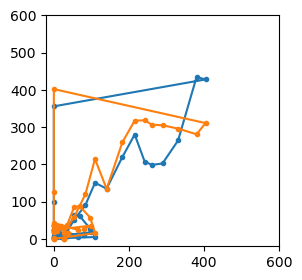

In [236]:
fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlim(-20,600)
ax.set_ylim(-20,600)


ax.plot(cum_open, DS.extent.values/40, marker='.')
ax.plot(cum_open, DS.length.values, marker='.')

In [101]:
np.nanmean(DS['width'])

20.977675430946313

In [ ]:

key = 'era'
mainpath = '../data/forcing/'
filename = f"dailymaps_{key}_v0.nc"
ds = xr.open_dataset(mainpath+filename)

In [61]:
DS.extent > 100

<xarray.DataArray 'extent' (time: 26)>
array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 2023-12-31 2024-01-01 ... 2024-01-25

In [219]:
stats = {}

stats['polynya'] = {}
months = [12,1,2,3,4]

for month in months:
    stats['polynya'][month] = 0

for ss in all_seqs:
    
    for date in all_seqs[ss]:
        
        stats['polynya'][date.month] += 1

In [336]:
all_force = {}


dt_i = timedelta(hours=24)
dt_f = timedelta(hours=24)

for ii in all_seqs.keys():

    # define time range
    ti = all_seqs[ii][0]
    tf = all_seqs[ii][-1] + timedelta(hours=23)
    time_range = slice(ti - dt_i, tf + dt_f)


    # open ERA5 data
    dse = grab_atm(time_range, lat = 70.5 , lon = -140, dt = 'hourly')
    dt = ((pd.to_datetime(dse.time.values) - pd.to_datetime(ti)) / np.timedelta64(1, 's')) * units('s').to('day')
    
    
    all_force[ii] = {}
    all_force[ii]['dt'] = dt
    all_force[ii]['u10'] = dse.u10.values
    all_force[ii]['v10'] = dse.v10.values
    all_force[ii]['msl'] = dse.msl.values / 100
    

In [389]:
stats['ESE_winds'] = {}
stats['strong_winds'] = {}
stats['strong_ESE_winds'] = {}

for month in months:
    stats['ESE_winds'][month] = 0
    stats['strong_winds'][month] = 0
    stats['strong_ESE_winds'][month] = 0

    
for year in years:
    
    print(year)
    
    # open ERA5 data
    time_range = slice(datetime(year,1,1) - timedelta(days=31), datetime(year,1,1) + timedelta(days=120))
    dse = grab_atm(time_range, lat = 70.5 , lon = -140, dt = 'daily')
    year_months = np.array([date.month for date in pd.to_datetime(dse.time.values)])
    
    wind_angles = vectors.vector_angle(dse.u10.values, dse.v10.values)
    wind_speeds = np.sqrt(dse.u10.values**2 + dse.v10.values**2)
    
    for month in months:
        month_angles = wind_angles[year_months == month].magnitude
        month_speeds = wind_speeds[year_months == month]
        
        within_angle_range = (month_angles > 135) & (month_angles < 180)
        within_speed_range = (month_speeds > 7.5)
        
        
        stats['ESE_winds'][month] += np.sum(within_angle_range)
        stats['strong_winds'][month] += np.sum(within_speed_range)
        stats['strong_ESE_winds'][month] += np.sum(within_angle_range&within_speed_range)
        

2018
2019
2020
2021
2022
2023
2024


In [344]:
back_u = np.array([])
back_v = np.array([])
back_m = np.array([])

for year in years:
    
    print(year)
    
    # open ERA5 data
    time_range = slice(datetime(year,1,1) - timedelta(days=31), datetime(year,1,1) + timedelta(days=120))
    dse = grab_atm(time_range, lat = 70.5 , lon = -140, dt = 'daily')
    
    back_u = np.append(back_u, dse.u10.values)
    back_v = np.append(back_v, dse.v10.values)
    back_m = np.append(back_m, dse.msl.values/100)
    
back_u = np.reshape(back_u, (len(years), int(back_u.size/len(years))))
back_v = np.reshape(back_v, (len(years), int(back_v.size/len(years))))
back_m = np.reshape(back_m, (len(years), int(back_m.size/len(years))))

2018
2019
2020
2021
2022
2023
2024


In [ ]:

key = 'era'
mainpath = '../data/forcing/'
filename = f"dailymaps_{key}_v0.nc"
ds = xr.open_dataset(mainpath+filename)

In [309]:
stats

{'polynya': {12: 8, 1: 17, 2: 0, 3: 9, 4: 7}}

In [305]:
stats['polynya']

{12: 8, 1: 17, 2: 0, 3: 9, 4: 7}

[Text(0, 0, '12'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4')]

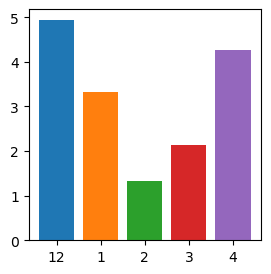

In [220]:
fig, ax = plt.subplots(figsize=(3,3))

for mm, month in enumerate(months):
    
    ax.bar(mm, stats['polynya'][month] / len(years))
#     ax.scatter(mm, stats['ESE_winds'][month] / len(years), c='gray')
#     ax.scatter(mm, stats['strong_ESE_winds'][month] / len(years), c='k')
#     ax.scatter(mm, stats['strong_winds'][month] / len(years), c='lightgray')
    
ax.set_xticks(range(len(months)))
ax.set_xticklabels(months)

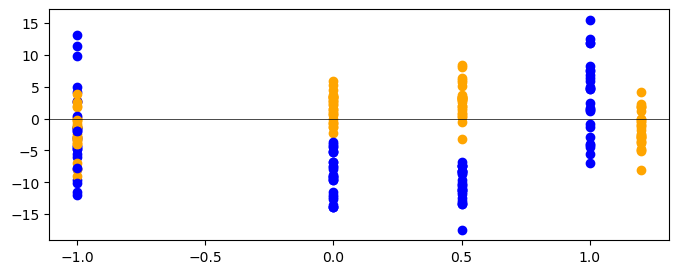

In [237]:
fig, ax = plt.subplots(figsize=(8,3))
ax.axhline(0, c='k', lw=0.5)


u_start = np.array([])
v_start = np.array([])

u_end = np.array([])
v_end = np.array([])

for ii in all_seqs.keys():

    seq = all_force[ii]
    
    
#     event_length = np.max(seq['dt']) - dt_f.days
#     dt_norm = (seq['dt']) / event_length

    dt = seq['dt']
    
    ind_start = np.where(dt == dt[dt_i.days*24])
    ind_end = np.where(dt == dt[-dt_f.days*24])
    
    ind_first = np.where((dt < 1) & (dt > -0.5))
    
    ind_final = np.where((dt > dt.max()-dt_f.days) & (dt < dt.max()))
    
    
    u_start = np.append(u_start, seq['u10'][ind_first])
    v_start = np.append(v_start, seq['v10'][ind_first])
    
    u_end = np.append(u_end, seq['u10'][ind_final])
    v_end = np.append(v_end, seq['v10'][ind_final])
    
    
    ax.scatter([-1], seq['u10'][0], c='b')
    ax.scatter([-1], seq['v10'][0], c='orange')
    
    
    
    ax.scatter([0], seq['u10'][24], c='b')
    ax.scatter([0], seq['v10'][24], c='orange')
    
    ax.scatter([0.5], seq['u10'][24+12], c='b')
    ax.scatter([0.5], seq['v10'][24+12], c='orange')
    
    
    ax.scatter([1], seq['u10'][-1], c='b')
    ax.scatter([1.2], seq['v10'][-1], c='orange')
    
    

In [224]:
dt.max()-dt_f.days

2.9583333333333326

In [340]:
np.nanmean(u_start) + np.nanmean(u_start)

-9.071467411619526

In [382]:
back_u

array([[  3.8389461 ,  -2.82555103,  -9.8918848 , ..., -10.26326752,
        -10.4566555 ,  -2.6198113 ],
       [ -6.86123133,  -3.49951482,  -2.09327817, ...,  -3.21595359,
         -0.82638049,   1.24201941],
       [ -7.43496084,  -9.48820591,  -1.15085363, ...,   4.88615179,
          3.07102418,  -4.65210772],
       ...,
       [ -1.63067245,   5.38300133,   4.05156994, ...,  -7.25163078,
         -2.97059369,  -6.49904585],
       [  1.69804752,   3.3758955 ,  17.41368866, ...,  -3.81374931,
         -6.7414031 ,  -7.88210106],
       [ -9.14648151,  -7.8623395 ,  -4.47210836, ...,  -5.46022844,
         -3.33055878,   1.97247684]])

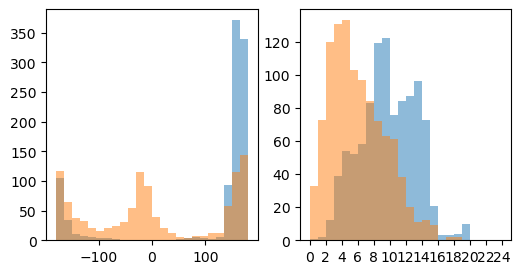

In [385]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

start_angles = vectors.vector_angle(u_start, v_start)
back_angles = vectors.vector_angle(back_u.flatten(), back_v.flatten())

start_speeds = np.sqrt(u_start**2 + v_start**2)
back_speeds = np.sqrt(back_u.flatten()**2 + back_v.flatten()**2)


# bins = np.arange(-25,25,1)
# ax = axs[0]
# ax.hist(u_start, bins=bins, alpha=0.5)
# ax.hist(v_start, bins=bins, alpha=0.5)

# ax = axs[1]
# ax.hist(back_u.flatten(), bins=bins, alpha=0.5)
# ax.hist(back_v.flatten(), bins=bins, alpha=0.5)

bins = np.arange(-180,181,15)
ax = axs[0]
ax.hist(start_angles, bins=bins, alpha=0.5)
ax.hist(back_angles, bins=bins, alpha=0.5)
# ax.set_xticks(bins[::2])


bins = np.arange(0,25,1)
ax = axs[1]
ax.hist(start_speeds, bins=bins, alpha=0.5)
ax.hist(back_speeds, bins=bins, alpha=0.5)
ax.set_xticks(bins[::2])

In [386]:
np.nanpercentile(start_speeds, 25)

7.488388434840175

In [388]:
np.nanpercentile(back_speeds, 75)

8.234381331488112

In [348]:
back_angles

<Quantity([ -47.29289544 -136.85631304 -179.70275804 ... -179.72167549 -179.18563574
  -25.92228881], 'degree')>

In [316]:
vectors.vector_angle(np.nanmean(u_start), np.nanmean(v_start))

<Quantity(165.294017, 'degree')>

In [315]:
vectors.vector_angle(np.nanmean(back_u.flatten()), np.nanmean(back_v.flatten()))

<Quantity(-170.122596, 'degree')>

In [ ]:

year = 2020

f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc'
# year1
DS1 = xr.open_dataset(file_name(time_range.start.year, dt))
DS1.close()
time_slice = slice(time_range.start, datetime(time_range.start.year, 12, 31, 23))
DS1 = DS1.sel(latitude = lat, longitude = lon, time=time_slice)


In [515]:
all_seqs

{0: [Timestamp('2017-12-03 00:00:00'),
  Timestamp('2017-12-04 00:00:00'),
  Timestamp('2017-12-05 00:00:00'),
  Timestamp('2017-12-06 00:00:00'),
  Timestamp('2017-12-07 00:00:00'),
  Timestamp('2017-12-08 00:00:00'),
  Timestamp('2017-12-09 00:00:00'),
  Timestamp('2017-12-10 00:00:00'),
  Timestamp('2017-12-11 00:00:00'),
  Timestamp('2017-12-12 00:00:00'),
  Timestamp('2017-12-13 00:00:00'),
  Timestamp('2017-12-14 00:00:00'),
  Timestamp('2017-12-15 00:00:00'),
  Timestamp('2017-12-16 00:00:00'),
  Timestamp('2017-12-17 00:00:00'),
  Timestamp('2017-12-18 00:00:00'),
  Timestamp('2017-12-19 00:00:00'),
  Timestamp('2017-12-20 00:00:00'),
  Timestamp('2017-12-21 00:00:00'),
  Timestamp('2017-12-22 00:00:00'),
  Timestamp('2017-12-23 00:00:00'),
  Timestamp('2017-12-24 00:00:00'),
  Timestamp('2017-12-25 00:00:00'),
  Timestamp('2017-12-26 00:00:00'),
  Timestamp('2017-12-27 00:00:00')],
 1: [Timestamp('2018-01-01 00:00:00'),
  Timestamp('2018-01-02 00:00:00'),
  Timestamp('2018-01-

array([2006, 2007, 2008, 2009, 2010, 2011, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024])

In [114]:

u_bg_sum = np.zeros((29, 161))
v_bg_sum = np.zeros((29, 161))
s_bg_sum = np.zeros((29, 161))
m_bg_sum = np.zeros((29, 161))
t_bg_sum = np.zeros((29, 161))

days_counter = 0

for year in years:
    
    print(year)
    
    # december
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year-1}_daily.nc')
    ds.close()
    ds = ds.sel(time = slice(datetime(year-1,12,1), datetime(year-1,12,31)), 
                latitude = lat_range, longitude = lon_range)
    speed = np.sqrt(ds.u10**2+ds.v10**2)
    
    u_bg_sum += ds.u10.sum(dim='time').values
    v_bg_sum += ds.v10.sum(dim='time').values
    s_bg_sum += speed.sum(dim='time').values
    m_bg_sum += ds.msl.sum(dim='time').values/100
    
    days_counter+=len(ds.time.values)
    
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year-1}.nc')
    ds.close()
    ds = ds.sel(valid_time = slice(datetime(year-1,12,1), datetime(year-1,12,31)), 
                latitude = lat_range, longitude = lon_range)
    t_bg_sum += (ds.t2m - 273.15).sum(dim='valid_time').values

    
    # december
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
    ds.close()
    ds = ds.sel(time = slice(datetime(year,1,1), datetime(year,4,30)), 
                latitude = lat_range, longitude = lon_range)
    speed = np.sqrt(ds.u10**2+ds.v10**2)
    
    u_bg_sum += ds.u10.sum(dim='time').values
    v_bg_sum += ds.v10.sum(dim='time').values
    s_bg_sum += speed.sum(dim='time').values
    m_bg_sum += ds.msl.sum(dim='time').values/100
    
    days_counter+=len(ds.time.values)
    
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year}.nc')
    ds.close()
    ds = ds.sel(valid_time = slice(datetime(year,1,1), datetime(year,4,30)), 
                latitude = lat_range, longitude = lon_range)
    t_bg_sum += (ds.t2m - 273.15).sum(dim='valid_time').values
    
    
    
    
u_bg_mean = u_bg_sum / days_counter
v_bg_mean = v_bg_sum / days_counter
s_bg_mean = s_bg_sum / days_counter
m_bg_mean = m_bg_sum / days_counter
t_bg_mean = t_bg_sum / days_counter
        

2006
2007
2008
2009
2010
2011
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [123]:
u_sum = np.zeros((29, 161))
v_sum = np.zeros((29, 161))
s_sum = np.zeros((29, 161))
m_sum = np.zeros((29, 161))
t_sum = np.zeros((29, 161))

lat_range = slice(75,68)
lon_range = slice(-165,-125)
    
    
counter = 0

for ss in all_seqs:
    
    date = all_seqs[ss][-1]
    
    print(date)
    
    u_event_sum = np.zeros((29, 161))
    v_event_sum = np.zeros((29, 161))
    s_event_sum = np.zeros((29, 161))
    m_event_sum = np.zeros((29, 161))
    t_event_sum = np.zeros((29, 161))
    
    event_counter = 0
    
    for date in all_seqs[ss]:
        year = date.year
        ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
        ds.close()
        ds = ds.sel(time = date, latitude = lat_range, longitude = lon_range)
        speed = np.sqrt(ds.u10**2+ds.v10**2)
        
        u_event_sum += ds.u10.values
        v_event_sum += ds.v10.values
        s_event_sum += speed.values
        m_event_sum += ds.msl.values/100
        
        ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year}.nc')
        ds.close()
        ds = ds.sel(valid_time = date, latitude = lat_range, longitude = lon_range)
        t_event_sum += (ds.t2m - 273.15).values

        event_counter+=1
        
        
        
    u_event_mean = u_event_sum / event_counter
    v_event_mean = v_event_sum / event_counter
    s_event_mean = s_event_sum / event_counter
    m_event_mean = m_event_sum / event_counter
    t_event_mean = t_event_sum / event_counter
    
    u_sum += u_event_mean
    v_sum += v_event_mean
    s_sum += s_event_mean
    m_sum += m_event_mean
    t_sum += t_event_mean
    
    counter+=1
    
    
u_mean = u_sum / counter
v_mean = v_sum / counter
s_mean = s_sum / counter
m_mean = m_sum / counter
t_mean = t_sum / counter


dc = np.sqrt(u_mean**2+v_mean**2) / s_mean

angles_mean = vectors.vector_angle(u_mean, v_mean).magnitude
angles_mean[angles_mean<0]+=360

2006-03-20 00:00:00
2007-02-10 00:00:00
2007-04-28 00:00:00
2007-12-15 00:00:00
2008-04-26 00:00:00
2008-12-11 00:00:00
2009-03-11 00:00:00
2009-12-30 00:00:00
2011-01-07 00:00:00
2016-02-17 00:00:00
2016-03-07 00:00:00
2016-04-14 00:00:00
2016-04-30 00:00:00
2016-12-08 00:00:00
2017-04-11 00:00:00
2017-04-19 00:00:00
2017-12-26 00:00:00
2018-01-03 00:00:00
2018-01-16 00:00:00
2018-04-12 00:00:00
2018-12-27 00:00:00
2019-01-19 00:00:00
2019-12-19 00:00:00
2020-12-03 00:00:00
2021-01-24 00:00:00
2021-04-30 00:00:00
2022-03-01 00:00:00
2022-03-29 00:00:00
2022-12-09 00:00:00
2022-12-12 00:00:00
2023-01-08 00:00:00
2023-01-15 00:00:00
2023-04-02 00:00:00
2024-01-18 00:00:00
2024-03-24 00:00:00
2024-04-01 00:00:00


In [163]:
dc_bg = np.sqrt(u_bg_mean**2+v_bg_mean**2) / s_bg_mean

In [164]:
total_vec_anom = np.sqrt((u_mean-u_bg_mean)**2 + (v_mean-v_bg_mean)**2)

angles_bg_mean = vectors.vector_angle(u_bg_mean, v_bg_mean).magnitude

angles_bg_mean[angles_bg_mean<0]+=360



In [165]:
total_vec_anom.shape

(29, 161)

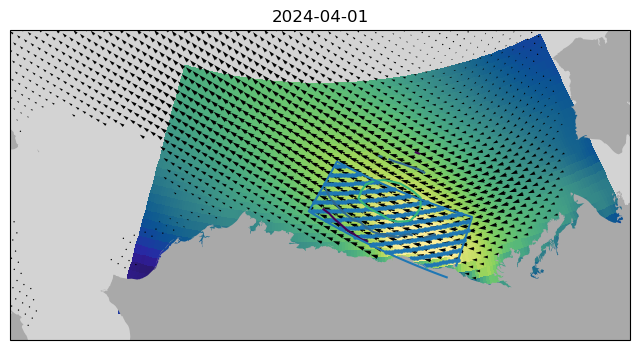

In [249]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-1000000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)
ax.set_title(date.date())
# geomap.scalebar(ax, loc=(0.55, 0.05), steps= [0,1,2,5,10,20], unit='km', label=None, 
#                 colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, bar_width=0.025,
#                 labelpad=0.015, ticklabelpad=0.01, zorder=100)

# ax.pcolormesh(ds.longitude, ds.latitude, ds.msl/100, vmin=1010, vmax=1030, transform=ccrs.PlateCarree())


# ax.pcolormesh(ds.longitude, ds.latitude, angles_mean-angles_bg_mean, vmin=-60,vmax=60, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


# ax.pcolormesh(ds.longitude, ds.latitude, u_mean-u_bg_mean, vmin=-10,vmax=10, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.pcolormesh(ds.longitude, ds.latitude, angles_mean, vmin=165-15,vmax=165+15, cmap='RdBu_r', transform=ccrs.PlateCarree())


ax.pcolormesh(ds.longitude, ds.latitude, total_vec_anom, vmin=0,vmax=8, cmap=cmocean.cm.haline, transform=ccrs.PlateCarree())



# ax.pcolormesh(ds.longitude, ds.latitude, t_bg_mean, vmin=-40, vmax=-10, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())
# ax.pcolormesh(ds.longitude, ds.latitude, t_event_mean, vmin=-40, vmax=-10, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())


# ax.pcolormesh(ds.longitude, ds.latitude, t_event_mean - t_bg_mean, vmin=-10, vmax=10, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.pcolormesh(drift['xx'], drift['yy'], np.nanmean(drift['e'], axis=0), vmin=-10, vmax=10, cmap=cmocean.cm.balance, transform=drift['proj'])


ia=200
ib=300
ja=110
jb=200
# ax.pcolormesh(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb], 
#               e_event_mean, vmin=-15, vmax=15, cmap=cmocean.cm.balance, transform=drift['proj'])

# ax.pcolormesh(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb], 
#               n_event_mean, vmin=-5, vmax=5, cmap=cmocean.cm.balance, transform=drift['proj'])



# ax.pcolormesh(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb], 
#               np.sqrt(e_event_mean**2+n_event_mean**2), vmin=-20, vmax=20, cmap=cmocean.cm.balance, transform=drift['proj'])


dlon_range = (drift['lon'][ia:ib, ja:jb] > 210) & (drift['lon'][ia:ib, ja:jb] < 220)
dlat_range = (drift['lat'][ia:ib, ja:jb] > 70.5) & (drift['lat'][ia:ib, ja:jb] < 73)
mask = (dlon_range & dlat_range)==False
ax.contour(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb], 
         ma.masked_where(mask, s_event_mean),  levels=[17,19,21,23], transform=drift['proj'])



# ax.quiver(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb],
#          np.mean(drift['u'][:,ia:ib, ja:jb], axis=0), np.mean(drift['v'][:,ia:ib, ja:jb], axis=0), transform=drift['proj'])

E, N = geomap.fix_cartopy_vectors(e_event_mean, n_event_mean, drift['lat'][ia:ib, ja:jb])
ax.quiver(drift['lon'][ia:ib, ja:jb], drift['lat'][ia:ib, ja:jb],
         E, N, transform=ccrs.PlateCarree())

# ax.contour(ds.longitude, ds.latitude, (1013.25 - ds.msl/100), levels=np.arange(-50,50), vmin=-30,vmax=30, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


ax.plot(df['lons'], df['lats'], transform=ccrs.PlateCarree())

ax.scatter(longrid[within_region], latgrid[within_region], s=5, transform=ccrs.PlateCarree())


In [212]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

e_sum = np.zeros((100, 90))
n_sum = np.zeros((100, 90))
s_sum = np.zeros((100, 90))
u_sum = np.zeros((100, 90))
v_sum = np.zeros((100, 90))

counter = 0 

for ss in all_seqs:
    
    date = all_seqs[ss][-1]
    
    print(date)

    try:
        drift = icedrift.open_local_file(all_seqs[ss],
                            main_path = '/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/', 
                            filenametype = 'icemotion_daily_nh_25km_{}0101_{}1231_v4.1.nc', 
                            include_units = False)

        e_event_mean = np.nanmean(drift['e'][:, ia:ib, ja:jb], axis=0)
        n_event_mean = np.nanmean(drift['n'][:, ia:ib, ja:jb], axis=0)
        s_event_mean = np.nanmean(np.sqrt(drift['e'][:, ia:ib, ja:jb]**2+drift['n'][:, ia:ib, ja:jb]**2), axis=0)
        u_event_mean = np.nanmean(drift['u'][:, ia:ib, ja:jb], axis=0)
        v_event_mean = np.nanmean(drift['v'][:, ia:ib, ja:jb], axis=0)
        

        e_sum += e_event_mean
        n_sum += n_event_mean
        s_sum += s_event_mean
        u_sum += u_event_mean
        v_sum += v_event_mean

        counter += 1
        
    except:
        print(f'missing {date} seq')
        
e_event_mean = e_sum/counter
n_event_mean = n_sum/counter
s_event_mean = s_sum/counter
u_event_mean = u_sum/counter
v_event_mean = v_sum/counter


warnings.filterwarnings("default", category=RuntimeWarning)

2006-03-20 00:00:00
2007-02-10 00:00:00
2007-04-28 00:00:00
2007-12-15 00:00:00
2008-04-26 00:00:00
2008-12-11 00:00:00
2009-03-11 00:00:00
2009-12-30 00:00:00
2011-01-07 00:00:00
2016-02-17 00:00:00
2016-03-07 00:00:00
2016-04-14 00:00:00
2016-04-30 00:00:00
2016-12-08 00:00:00
2017-04-11 00:00:00
2017-04-19 00:00:00
2017-12-26 00:00:00
2018-01-03 00:00:00
2018-01-16 00:00:00
2018-04-12 00:00:00
2018-12-27 00:00:00
2019-01-19 00:00:00
2019-12-19 00:00:00
2020-12-03 00:00:00
2021-01-24 00:00:00
2021-04-30 00:00:00
2022-03-01 00:00:00
2022-03-29 00:00:00
2022-12-09 00:00:00
2022-12-12 00:00:00
2023-01-08 00:00:00
2023-01-15 00:00:00
2023-04-02 00:00:00
2024-01-18 00:00:00
missing 2024-01-18 00:00:00 seq
2024-03-24 00:00:00
missing 2024-03-24 00:00:00 seq
2024-04-01 00:00:00
missing 2024-04-01 00:00:00 seq


In [ ]:


drift = icedrift.open_local_file(all_seqs[1],
                        main_path = '/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/', 
                        filenametype = 'icemotion_daily_nh_25km_{}0101_{}1231_v4.1.nc', 
                        include_units = False)
ia=200
ib=300
ja=110
jb=200

e_event_sum = np.zeros((100, 90))

In [150]:
np.nanmean(drift['e'][:, ia:ib, ja:jb], axis=0)

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_4034/1880086631.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(drift['e'][:, ia:ib, ja:jb], axis=0)


array([[       nan,        nan,        nan, ..., -2.8658433, -2.72789  ,
        -2.3834352],
       [       nan,        nan,        nan, ..., -2.8545237, -2.5814705,
        -2.2634492],
       [       nan,        nan,        nan, ..., -3.0014875, -2.6279378,
        -2.2171466],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)

In [256]:
grids['pp']['lon'].shape

(100, 90)

In [251]:
drift.keys()

dict_keys(['ds', 'proj', 'u', 'v', 'error', 'xx', 'yy', 'lat', 'lon', 'e', 'n'])

era
pp


In [259]:
grids[key]

{'lat': array([[73.53185 , 73.75072 , 73.96927 , ..., 84.08011 , 83.93147 ,
         83.77819 ],
        [73.467834, 73.68586 , 73.903564, ..., 83.90636 , 83.76184 ,
         83.61262 ],
        [73.40095 , 73.61811 , 73.83492 , ..., 83.72928 , 83.588745,
         83.443436],
        ...,
        [58.883606, 59.003098, 59.121273, ..., 63.101437, 63.067146,
         63.030945],
        [58.682526, 58.801323, 58.918808, ..., 62.871983, 62.837963,
         62.80204 ],
        [58.4809  , 58.59901 , 58.715816, ..., 62.64238 , 62.608624,
         62.57298 ]], dtype=float32),
 'lon': array([[-105.945404, -106.16449 , -106.38954 , ...,  139.63547 ,
          138.01279 ,  136.4688  ],
        [-106.69925 , -106.92752 , -107.16193 , ...,  141.009   ,
          139.39871 ,  137.86241 ],
        [-107.44719 , -107.68439 , -107.92792 , ...,  142.30576 ,
          140.71059 ,  139.18492 ],
        ...,
        [-149.1083  , -149.47029 , -149.83499 , ...,  171.73283 ,
          171.25385 ,  170.7760

## Regional statistics

In [702]:
var_means = {}

groups = ['u10', 'v10', 'msl', 's10']

for group in groups:
    
    var_means[group] = np.array([])


for ss in all_seqs:
    
    date = all_seqs[ss][-1]
    print(date, len(all_seqs[ss]))
    
    for date in all_seqs[ss][:-1]:
        
        year = date.year
        ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
        ds.close()
        ds = ds.sel(time = date, latitude = lat_range, longitude = lon_range)
        speed = np.sqrt(ds.u10**2+ds.v10**2)
        
        curr = {}
        curr['u10'] = geogen.lat_weighted_mean(ds.u10.values[within_region], latgrid[within_region])
        curr['v10'] = geogen.lat_weighted_mean(ds.v10.values[within_region], latgrid[within_region])
        curr['msl'] = geogen.lat_weighted_mean(ds.msl.values[within_region], latgrid[within_region])
        curr['s10'] = geogen.lat_weighted_mean(speed.values[within_region], latgrid[within_region])
        
        for group in groups:
            var_means[group] = np.append(var_means[group], curr[group])
            
            

        

2002-12-02 00:00:00 2
2002-12-11 00:00:00 2
2002-12-24 00:00:00 2
2003-01-12 00:00:00 3
2003-01-21 00:00:00 3
2003-01-28 00:00:00 3
2003-12-22 00:00:00 12
2004-01-01 00:00:00 4
2004-01-13 00:00:00 3
2004-12-05 00:00:00 5
2004-12-21 00:00:00 5
2006-03-20 00:00:00 6
2006-12-18 00:00:00 3
2007-02-10 00:00:00 4
2007-04-28 00:00:00 10
2007-12-15 00:00:00 13
2007-12-25 00:00:00 2
2008-02-14 00:00:00 3
2008-04-26 00:00:00 4
2008-12-11 00:00:00 3
2009-03-11 00:00:00 2
2009-12-23 00:00:00 2
2009-12-30 00:00:00 3
2011-01-07 00:00:00 4
2012-12-25 00:00:00 3
2013-01-16 00:00:00 3
2013-03-11 00:00:00 6
2013-03-17 00:00:00 2
2014-01-08 00:00:00 10
2014-01-29 00:00:00 2
2014-03-02 00:00:00 3
2014-04-26 00:00:00 2
2015-01-02 00:00:00 2
2015-02-25 00:00:00 2
2015-12-17 00:00:00 3
2016-01-30 00:00:00 5
2016-02-17 00:00:00 10
2016-03-07 00:00:00 11
2016-03-10 00:00:00 2
2016-03-23 00:00:00 2
2016-04-14 00:00:00 10
2016-04-30 00:00:00 12
2016-12-08 00:00:00 3
2016-12-19 00:00:00 4
2017-04-11 00:00:00 7
20

In [693]:
e, n = vectors.rotate_vector(var_means['u10'], var_means['v10'], -20*units('degree'))

<IPython.core.display.Javascript object>


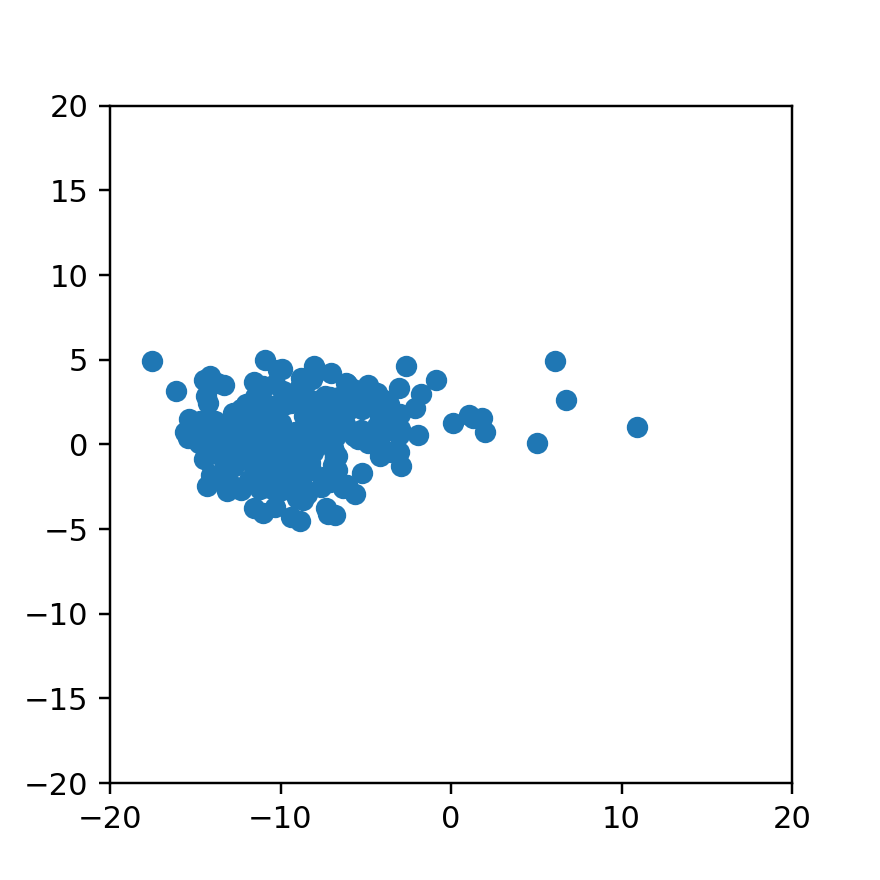

In [703]:

bins = np.arange(-20,20,0.5)

fig, ax = plt.subplots(figsize=(4,4))

size = 20

ax.set_xlim(-size, size)
ax.set_ylim(-size, size)

# plt.hist(var_means['u10'], bins=bins)
# plt.hist(var_means['v10'], bins=bins)


# plt.hist(e, bins=bins, alpha=0.5)
# plt.hist(n, bins=bins, alpha=0.5)

plt.scatter(var_means['u10'], var_means['v10'])


<IPython.core.display.Javascript object>


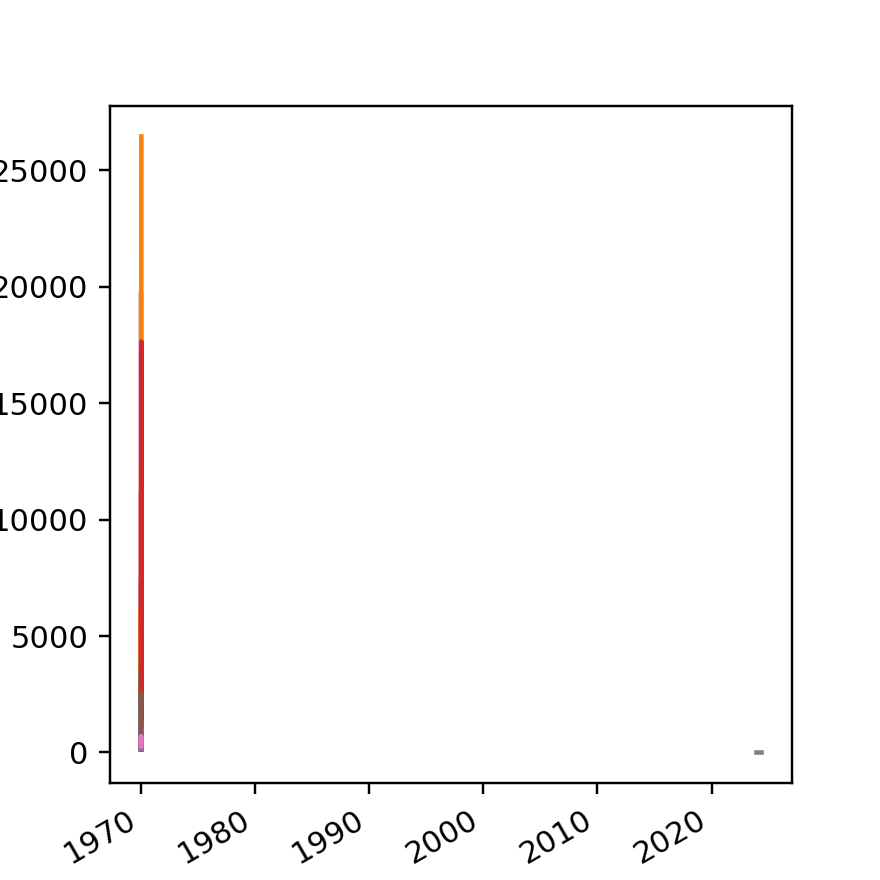

In [710]:
fig, ax = plt.subplots(figsize=(4,4))

for ss in all_sizes:
    
    plt.plot(all_sizes[ss])

In [831]:
all_seqs

{0: [Timestamp('2002-12-01 00:00:00'), Timestamp('2002-12-02 00:00:00')],
 1: [Timestamp('2002-12-10 00:00:00'), Timestamp('2002-12-11 00:00:00')],
 2: [Timestamp('2002-12-23 00:00:00'), Timestamp('2002-12-24 00:00:00')],
 3: [Timestamp('2003-01-10 00:00:00'),
  Timestamp('2003-01-11 00:00:00'),
  Timestamp('2003-01-12 00:00:00')],
 4: [Timestamp('2003-01-19 00:00:00'),
  Timestamp('2003-01-20 00:00:00'),
  Timestamp('2003-01-21 00:00:00')],
 5: [Timestamp('2003-01-26 00:00:00'),
  Timestamp('2003-01-27 00:00:00'),
  Timestamp('2003-01-28 00:00:00')],
 6: [Timestamp('2003-12-11 00:00:00'),
  Timestamp('2003-12-12 00:00:00'),
  Timestamp('2003-12-13 00:00:00'),
  Timestamp('2003-12-14 00:00:00'),
  Timestamp('2003-12-15 00:00:00'),
  Timestamp('2003-12-16 00:00:00'),
  Timestamp('2003-12-17 00:00:00'),
  Timestamp('2003-12-18 00:00:00'),
  Timestamp('2003-12-19 00:00:00'),
  Timestamp('2003-12-20 00:00:00'),
  Timestamp('2003-12-21 00:00:00'),
  Timestamp('2003-12-22 00:00:00')],
 7: [T

In [731]:
all_seqs[5]

[Timestamp('2019-01-15 00:00:00'),
 Timestamp('2019-01-16 00:00:00'),
 Timestamp('2019-01-17 00:00:00'),
 Timestamp('2019-01-18 00:00:00'),
 Timestamp('2019-01-19 00:00:00')]

In [784]:
DS

<xarray.Dataset>
Dimensions:               (time: 16)
Coordinates:
  * time                  (time) datetime64[ns] 2019-12-06 ... 2019-12-21
Data variables: (12/24)
    N                     (time) float64 ...
    extent                (time) float64 nan nan 155.9 975.0 ... 623.8 nan nan
    l_min                 (time) float64 ...
    l_max                 (time) float64 ...
    l_mean                (time) float64 ...
    l_per5                (time) float64 ...
    ...                    ...
    land_extent           (time) float64 ...
    ice_extent            (time) float64 ...
    ocean_extent          (time) float64 ...
    other_polynya_extent  (time) float64 ...
    polynya_extent        (time) float64 ...
    miss_flag             (time) bool ...

In [817]:
all_seqs

{0: [Timestamp('2002-12-01 00:00:00'), Timestamp('2002-12-02 00:00:00')],
 1: [Timestamp('2002-12-10 00:00:00'), Timestamp('2002-12-11 00:00:00')],
 2: [Timestamp('2002-12-23 00:00:00'), Timestamp('2002-12-24 00:00:00')],
 3: [Timestamp('2003-01-10 00:00:00'),
  Timestamp('2003-01-11 00:00:00'),
  Timestamp('2003-01-12 00:00:00')],
 4: [Timestamp('2003-01-19 00:00:00'),
  Timestamp('2003-01-20 00:00:00'),
  Timestamp('2003-01-21 00:00:00')],
 5: [Timestamp('2003-01-26 00:00:00'),
  Timestamp('2003-01-27 00:00:00'),
  Timestamp('2003-01-28 00:00:00')],
 6: [Timestamp('2003-12-11 00:00:00'),
  Timestamp('2003-12-12 00:00:00'),
  Timestamp('2003-12-13 00:00:00'),
  Timestamp('2003-12-14 00:00:00'),
  Timestamp('2003-12-15 00:00:00'),
  Timestamp('2003-12-16 00:00:00'),
  Timestamp('2003-12-17 00:00:00'),
  Timestamp('2003-12-18 00:00:00'),
  Timestamp('2003-12-19 00:00:00'),
  Timestamp('2003-12-20 00:00:00'),
  Timestamp('2003-12-21 00:00:00'),
  Timestamp('2003-12-22 00:00:00')],
 7: [T

In [840]:
ss = 12

event_u = np.array([])
event_v = np.array([])

event_times = pd.date_range(all_seqs[ss][0] - timedelta(days=2), all_seqs[ss][-1] + timedelta(days=2))

print(event_times)

# open data and crop to time range
year = all_seqs[ss][-1].year
if all_seqs[ss][-1].month == 12:
    year+=1
DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{year}_sic15_v3.nc')
DS = DS.sel(time = event_times)
DS['length'] = DS['l_max'] - DS['l_min']
    
for date in event_times:
    
    year = date.year
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
    ds.close()
    ds = ds.sel(time = date, latitude = lat_range, longitude = lon_range)
    speed = np.sqrt(ds.u10**2+ds.v10**2)
    
    u = geogen.lat_weighted_mean(ds.u10.values[within_region], latgrid[within_region])
    v = geogen.lat_weighted_mean(ds.v10.values[within_region], latgrid[within_region])
    
    event_u = np.append(event_u, u)
    event_v = np.append(event_v, v)
    
event_ese = vectors.comp_along_theta(event_u, event_v, 165 * units('degree'))

wind_drift = 0.03 * event_ese * units('m/s').to('km/day').magnitude
wind_growth = np.cumsum(wind_drift)

DatetimeIndex(['2006-12-14', '2006-12-15', '2006-12-16', '2006-12-17',
               '2006-12-18', '2006-12-19', '2006-12-20'],
              dtype='datetime64[ns]', freq='D')


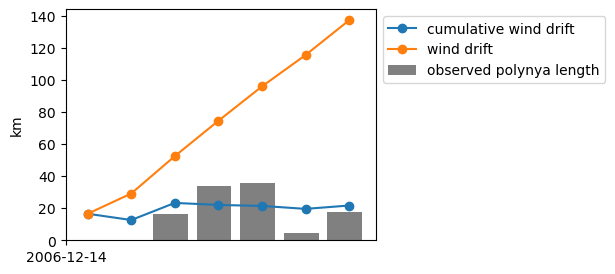

In [841]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(event_times+timedelta(hours=12), wind_drift, marker='o', label='cumulative wind drift')
plt.plot(event_times+timedelta(hours=12), wind_growth, marker='o', label='wind drift')
plt.bar(DS.time, DS.length, color='gray', align='edge', label='observed polynya length')
# plt.bar(DS.time, DS.polynya_extent/50, color='b', align='edge')

ax.set_xticks(event_times[::7])
ax.set_ylabel('km')
plt.legend(bbox_to_anchor=(1,1))

In [804]:

print(DS.time, DS.length)

<xarray.DataArray 'time' (time: 7)>
array(['2022-02-25T00:00:00.000000000', '2022-02-26T00:00:00.000000000',
       '2022-02-27T00:00:00.000000000', '2022-02-28T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2022-03-02T00:00:00.000000000',
       '2022-03-03T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-02-25 2022-02-26 ... 2022-03-03 <xarray.DataArray 'length' (time: 7)>
array([         nan,          nan,  95.06044931, 118.09418008,
       131.63396792,          nan,          nan])
Coordinates:
  * time     (time) datetime64[ns] 2022-02-25 2022-02-26 ... 2022-03-03


In [809]:
DS.polynya_extent

<xarray.DataArray 'polynya_extent' (time: 7)>
array([   0.      ,    0.      , 2106.763029, 3591.492329, 3553.172858,
               nan,    0.      ])
Coordinates:
  * time     (time) datetime64[ns] 2022-02-25 2022-02-26 ... 2022-03-03
Attributes:
    long_name:  extent of polynya forming near HI within region
    units:      km^2

In [34]:
lat_range = slice(76,68)
lon_range = slice(-165,-125)
    
    
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_2019.nc')
ds.close()

T2M = ds.t2m.sel(latitude=lat_range, longitude=lon_range).sel(valid_time = datetime(2019,1,18))

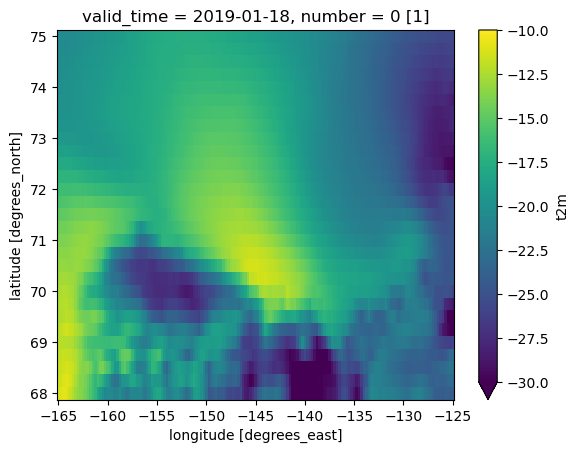

In [35]:
(T2M-273.15).plot(vmin=-30, vmax=-10)